# Deep Q-Learning

In [ ]:
#@title Imports das Bibliotecas

# Consolidando e removendo duplicatas, usando sempre tensorflow.keras
import os, random, math, warnings, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy.special import expit
from collections import deque
from tqdm import tqdm
from tensorflow.keras.models import load_model

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
#@title Definindo seeds para reprodutibilidade
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
#@title Ativando mixed precision e XLA JIT
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

warnings.filterwarnings('ignore')


# Carregando Dados

In [ ]:
# Parâmetro de caminho torna mais portátil
DATA_PATH = os.getenv('SP500_CSV', '/content/SP500.csv')
dataset = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)

# Relatório de nulos
n_nulos = dataset.isna().sum().sum()
print(f'Preenchendo {n_nulos} valores nulos com ffill')
dataset.fillna(method='ffill', inplace=True)

Preenchendo 0 valores nulos com ffill


# Análise Exploratória dos Dados (EDA)

In [ ]:
#@title Verificando Tamanho e Plotando Gráfico

print("Shape:", dataset.shape)
display(dataset.head())
display(dataset.describe())

# Candlestick interativo
fig = go.Figure(data=[go.Candlestick(
    x=dataset.index,
    open=dataset['Open'],
    high=dataset['High'],
    low=dataset['Low'],
    close=dataset['Close']
)])
fig.update_layout(title='S&P 500 Candlestick')
fig.show()

Shape: (2516, 6)


Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-01-04  1116.560059  1133.869995  1116.560059  1132.989990  1132.989990   
2010-01-05  1132.660034  1136.630005  1129.660034  1136.520020  1136.520020   
2010-01-06  1135.709961  1139.189941  1133.949951  1137.140015  1137.140015   
2010-01-07  1136.270020  1142.459961  1131.319946  1141.689941  1141.689941   
2010-01-08  1140.520020  1145.390015  1136.219971  1144.979980  1144.979980   

                Volume  
Date                    
2010-01-04  3991400000  
2010-01-05  2491020000  
2010-01-06  4972660000  
2010-01-07  5270680000  
2010-01-08  4389590000

Open         High          Low        Close    Adj Close  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean   1962.147905  1971.346574  1952.200450  1962.608854  1962.608854   
std     589.031496   590.190988   587.623893   588.910251   588.910251   
min    1027.650024  1032.949951  1010.909973  1022.580017  1022.580017   
25%    1381.642548  1390.700012  1372.800018  1384.404999  1384.404999   
50%    1985.319946  1993.084961  1975.660034  1986.479981  1986.479981   
75%    2434.179931  2441.522522  2427.959961  2433.967529  2433.967529   
max    3247.229980  3247.929932  3234.370117  3240.020020  3240.020020   

             Volume  
count  2.516000e+03  
mean   3.715246e+09  
std    8.134033e+08  
min    1.025000e+09  
25%    3.237625e+09  
50%    3.587920e+09  
75%    4.076530e+09  
max    1.061781e+10

# Preparação dos Dados

In [ ]:
# Preparando série de fechamento
prices = dataset['Close'].astype(float).tolist()

# Train / Test split
VAL_SPLIT = 0.2
split_i = int(len(prices)*(1-VAL_SPLIT))
X_train, X_test = prices[:split_i], prices[split_i:]
print(f'Train size: {len(X_train)}, Test size: {len(X_test)}')

Train size: 2012, Test size: 504


# Avaliando Modelos e Algoritmos


In [ ]:
#@title Agente Deep Q-Learning
class Agent:
    def __init__(self, state_size, is_eval=False, model_name="", memory_size=10000,
                 gamma=0.95, epsilon=1.0, eps_min=0.01, eps_decay=0.995, lr=1e-3):
        self.state_size = state_size
        self.action_size = 3  # 0: hold, 1: buy, 2: sell
        self.memory = deque(maxlen=memory_size)
        self.inventory = []
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = eps_min
        self.epsilon_decay = eps_decay

        if is_eval and model_name:
            self.model = load_model(model_name)
        else:
            self.model = self._build_model(lr)

    def _build_model(self, lr):
        model = Sequential([
            Dense(64, activation='relu', input_shape=(self.state_size,)),
            Dense(32, activation='relu'),
            Dense(8, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=lr))
        return model

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_size)
        q = self.model.predict(state, verbose=0)
        return np.argmax(q[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        states = np.vstack([m[0] for m in minibatch])
        next_states = np.vstack([m[3] for m in minibatch])
        actions = np.array([m[1] for m in minibatch])
        rewards = np.array([m[2] for m in minibatch])
        dones = np.array([m[4] for m in minibatch]).astype(int)

        # Previsões em batch
        q_next = self.model.predict(next_states, verbose=0)
        q_current = self.model.predict(states, verbose=0)

        max_q_next = np.max(q_next, axis=1)
        targets = rewards + (1 - dones) * self.gamma * max_q_next
        q_current[np.arange(batch_size), actions] = targets

        # Fit único em batch
        self.model.fit(states, q_current, epochs=1, batch_size=batch_size, verbose=0)

        # Decaimento de epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# Funções Auxiliares

In [ ]:
def format_price(n):
    sign = '-' if n < 0 else ''
    return f"{sign}${abs(n):.2f}"

def get_state(data, t, n):
    start = max(0, t - n + 1)
    block = data[start:t+1]
    if len(block) < n:
        block = [data[0]]*(n-len(block)) + block
    diffs = np.diff(block)
    return expit(diffs).reshape(1, -1)

def plot_behavior(data, buy_pts, sell_pts, profit):
    plt.figure(figsize=(15,5))
    plt.plot(data, label='Preço')
    plt.scatter(buy_pts, [data[i] for i in buy_pts], marker='^', s=100, label='Compra')
    plt.scatter(sell_pts, [data[i] for i in sell_pts], marker='v', s=100, label='Venda')
    plt.title(f'Lucro total: {format_price(profit)}')
    plt.legend()
    plt.show()


# Treinamento dos Dados

Episódios:   0%|          | 0/50 [00:00<?, ?it/s]


Episódio 1 — Lucro: $989.16


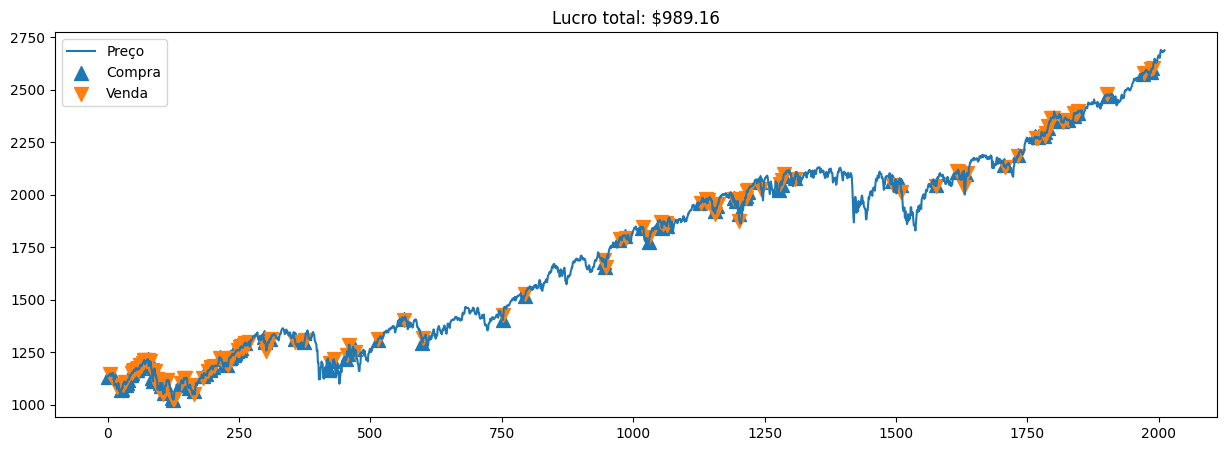

Episódios:   2%|▏         | 1/50 [10:06<8:14:54, 606.02s/it]


Episódio 2 — Lucro: $250.58


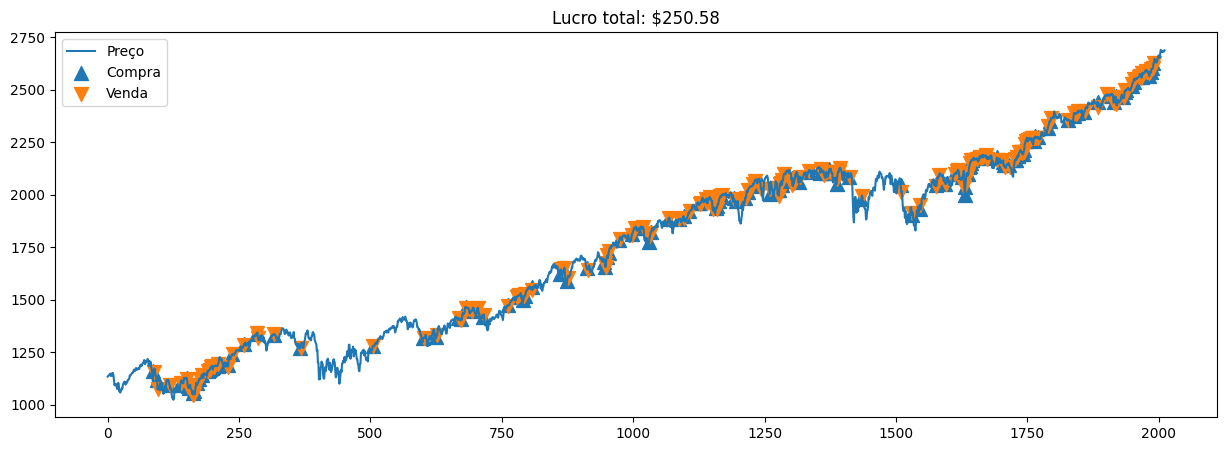

Episódios:   4%|▍         | 2/50 [20:58<8:26:39, 633.32s/it]


Episódio 3 — Lucro: $282.66


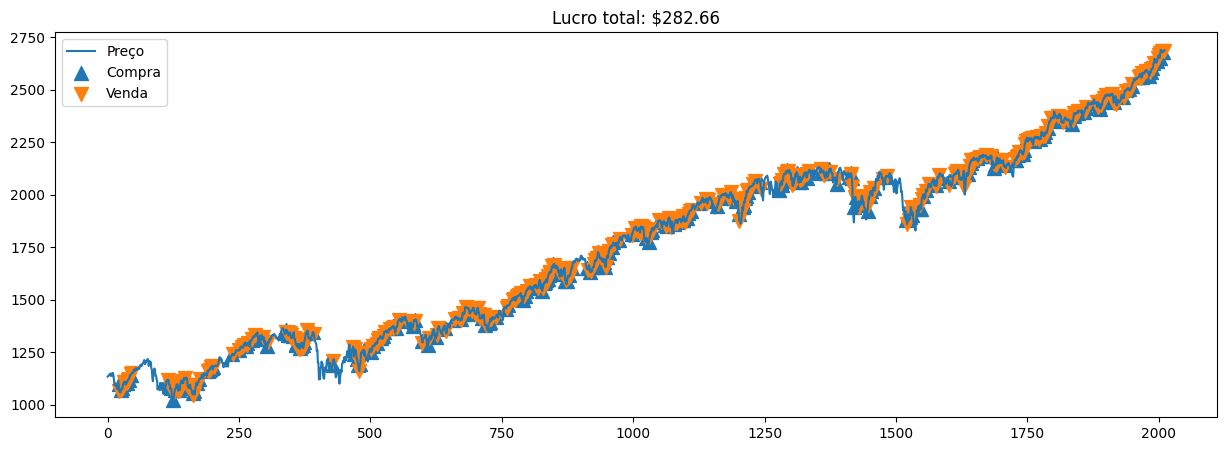

Episódios:   6%|▌         | 3/50 [32:05<8:28:01, 648.54s/it]


Episódio 4 — Lucro: $151.86


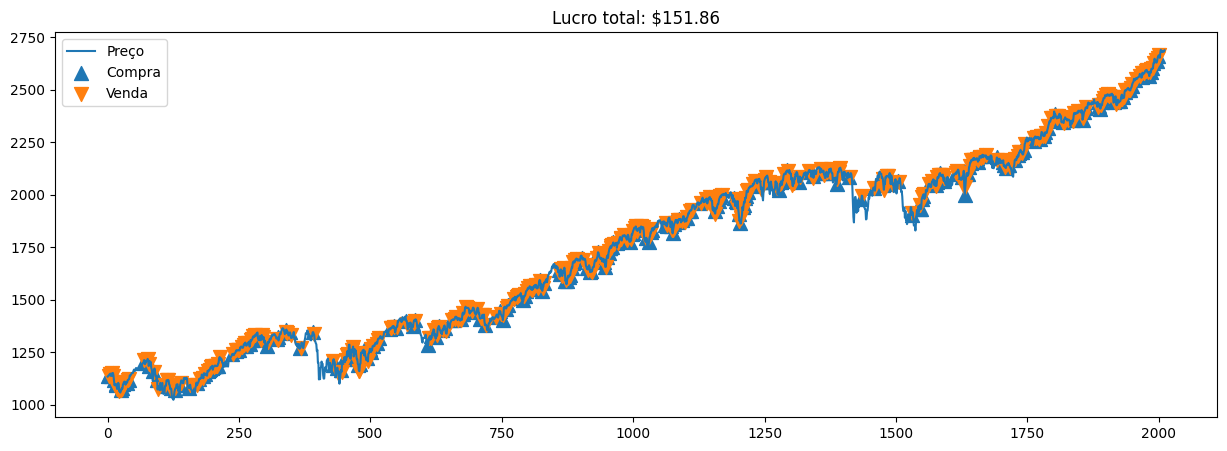

Episódios:   8%|▊         | 4/50 [43:15<8:23:47, 657.12s/it]


Episódio 5 — Lucro: $1309.43


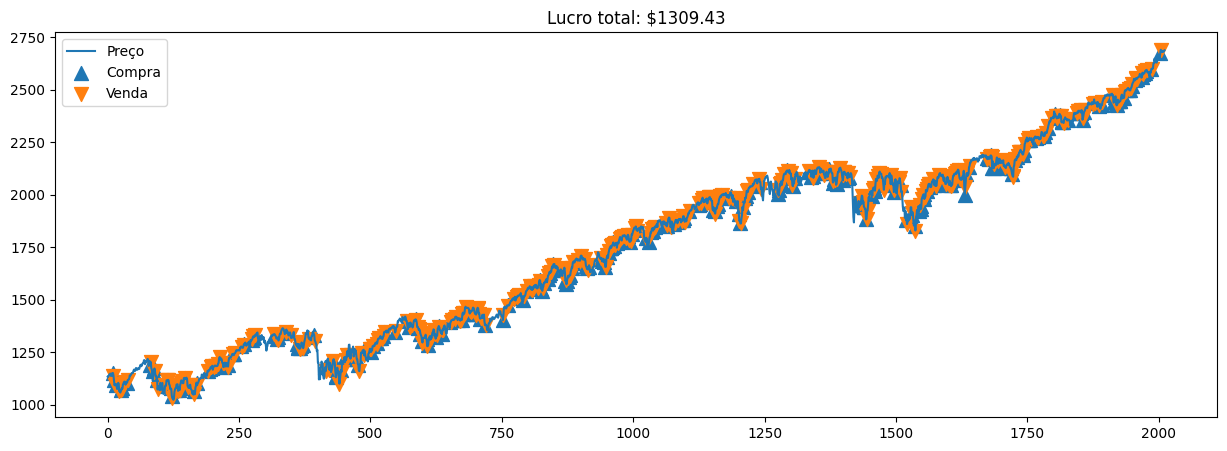

Episódios:  10%|█         | 5/50 [54:23<8:15:46, 661.03s/it]


Episódio 6 — Lucro: $1890.68


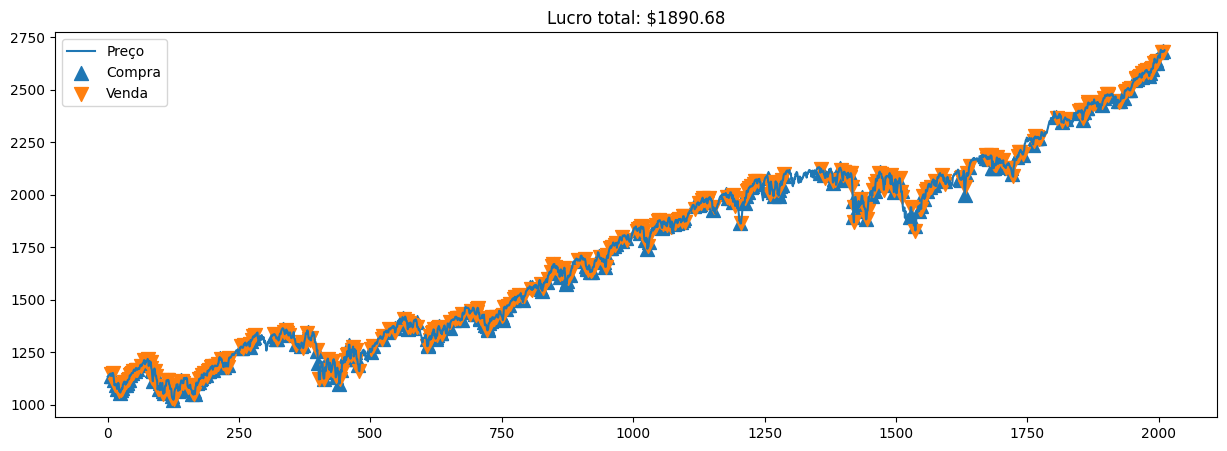

Episódios:  12%|█▏        | 6/50 [1:05:34<8:07:14, 664.41s/it]


Episódio 7 — Lucro: $1167.98


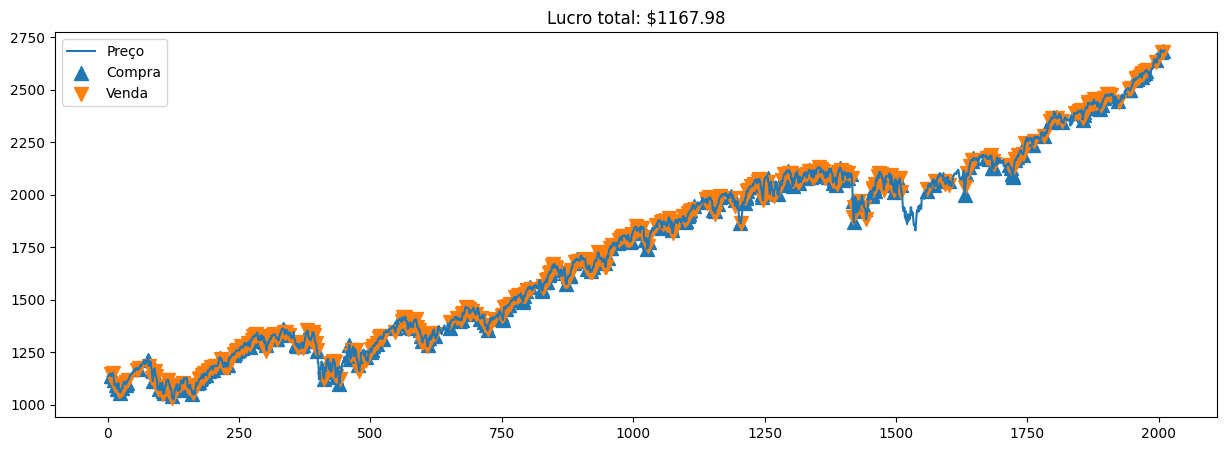

Episódios:  14%|█▍        | 7/50 [1:16:45<7:57:51, 666.78s/it]


Episódio 8 — Lucro: $550.02


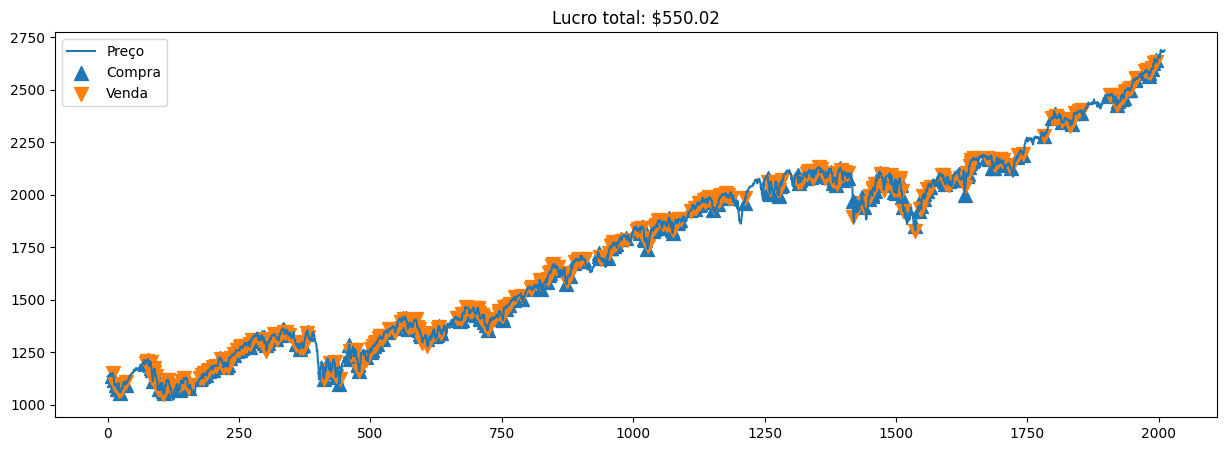

Episódios:  16%|█▌        | 8/50 [1:27:54<7:47:13, 667.47s/it]


Episódio 9 — Lucro: $944.50


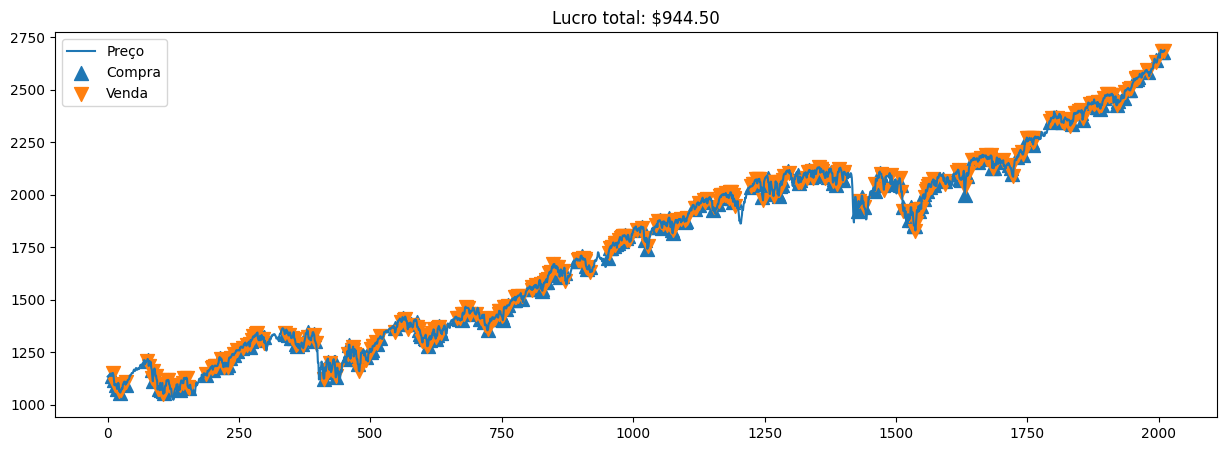

Episódios:  18%|█▊        | 9/50 [1:39:08<7:37:21, 669.30s/it]


Episódio 10 — Lucro: $435.42


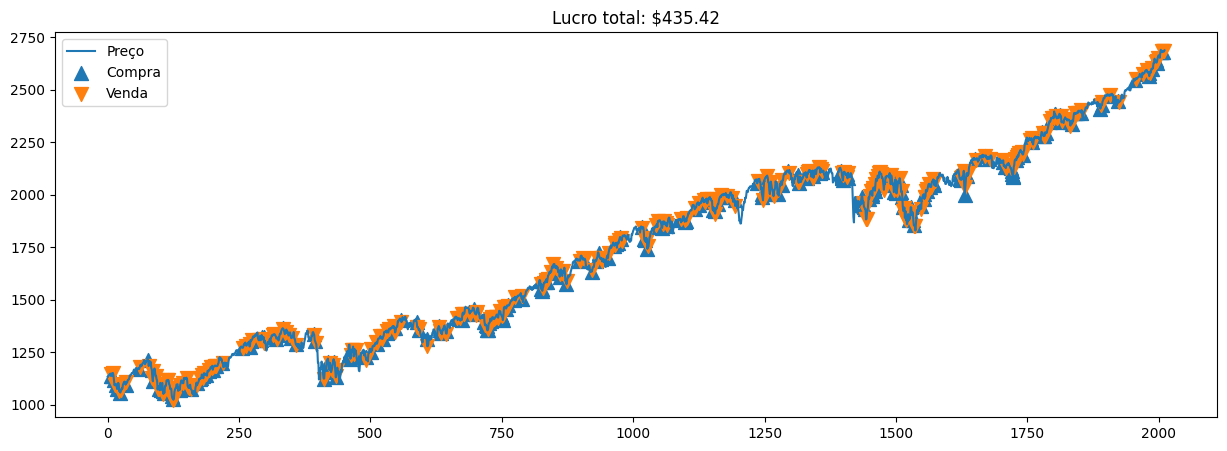

Episódios:  20%|██        | 10/50 [1:50:23<7:27:29, 671.24s/it]


Episódio 11 — Lucro: $463.70


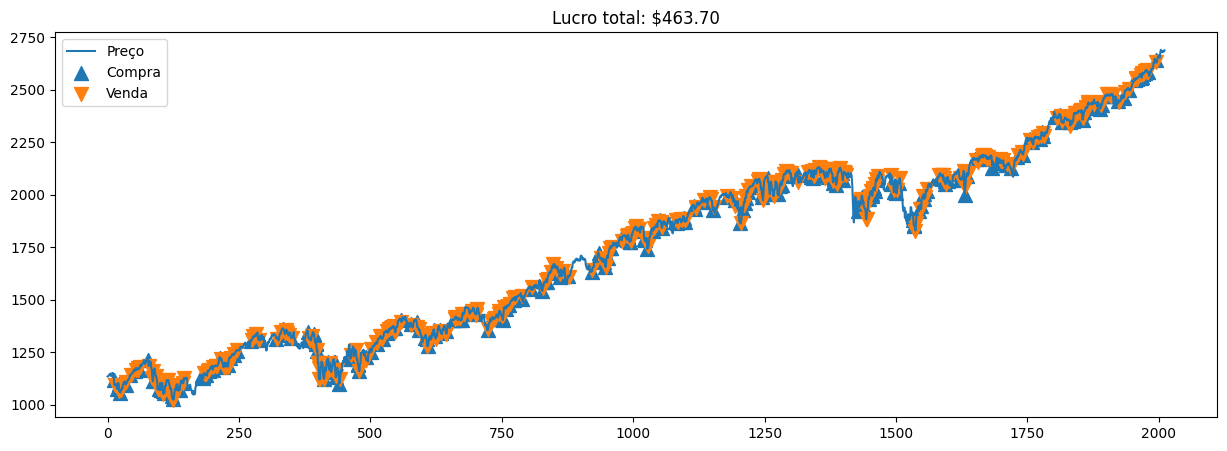

Episódios:  22%|██▏       | 11/50 [2:01:41<7:17:33, 673.16s/it]


Episódio 12 — Lucro: $15.49


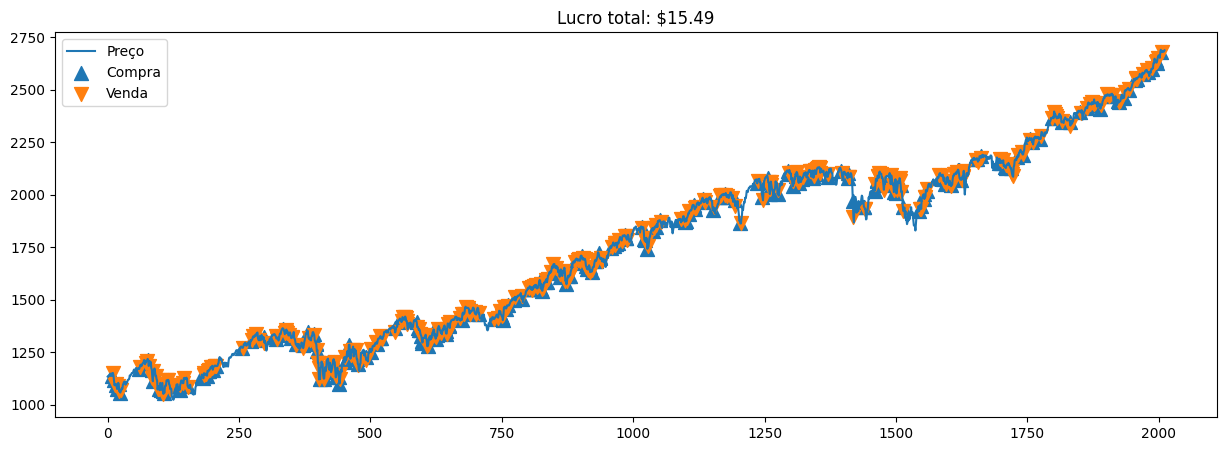

Episódios:  24%|██▍       | 12/50 [2:12:50<7:05:29, 671.84s/it]


Episódio 13 — Lucro: $752.22


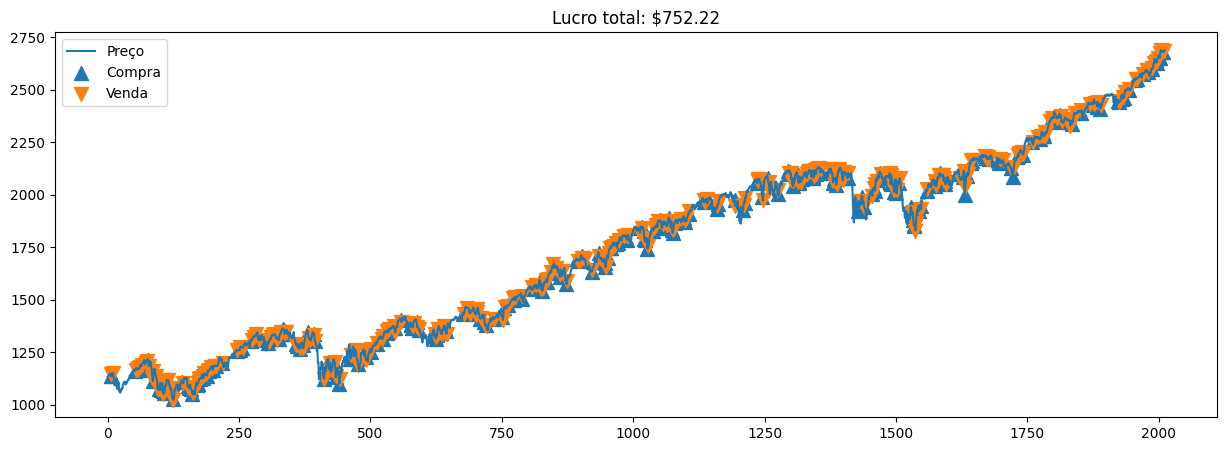

Episódios:  26%|██▌       | 13/50 [2:23:58<6:53:36, 670.71s/it]


Episódio 14 — Lucro: $643.88


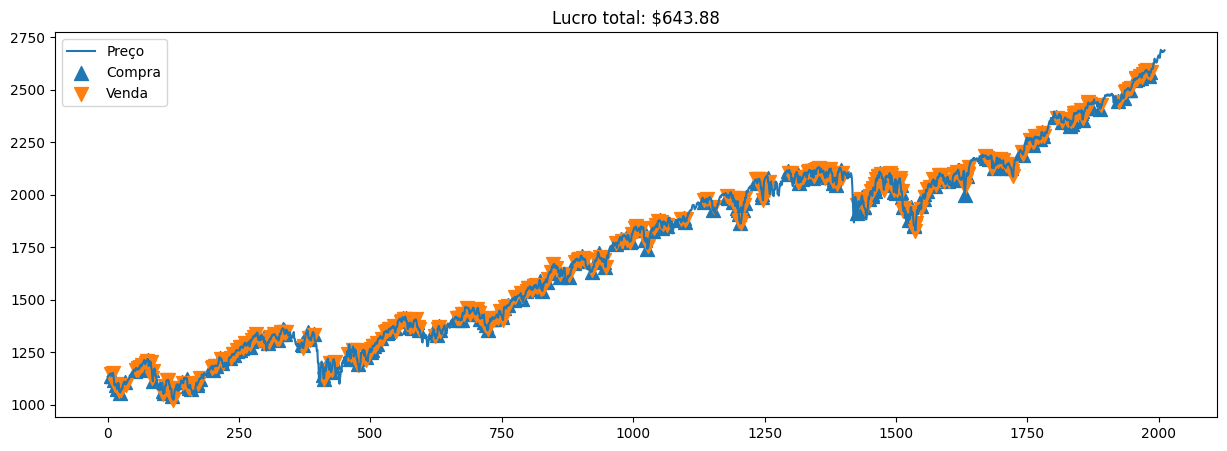

Episódios:  28%|██▊       | 14/50 [2:35:05<6:41:48, 669.67s/it]


Episódio 15 — Lucro: $711.23


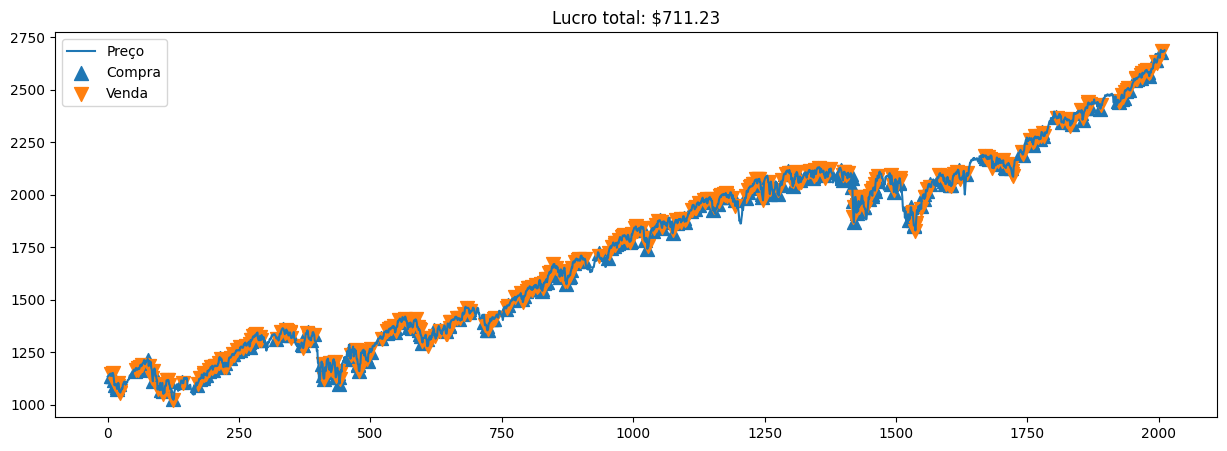

Episódios:  30%|███       | 15/50 [2:46:09<6:29:42, 668.08s/it]


Episódio 16 — Lucro: $1956.54


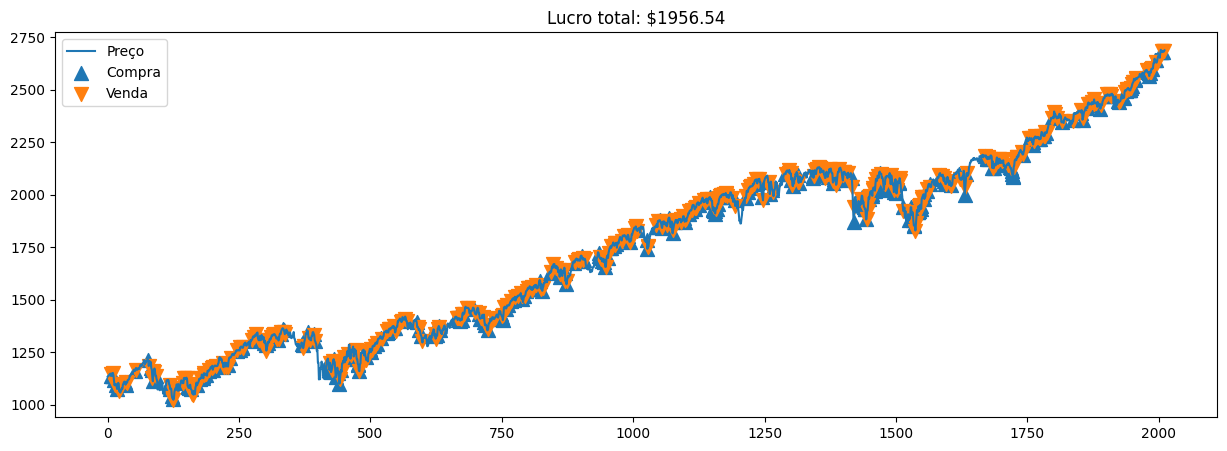

Episódios:  32%|███▏      | 16/50 [2:57:12<6:17:42, 666.54s/it]


Episódio 17 — Lucro: $566.64


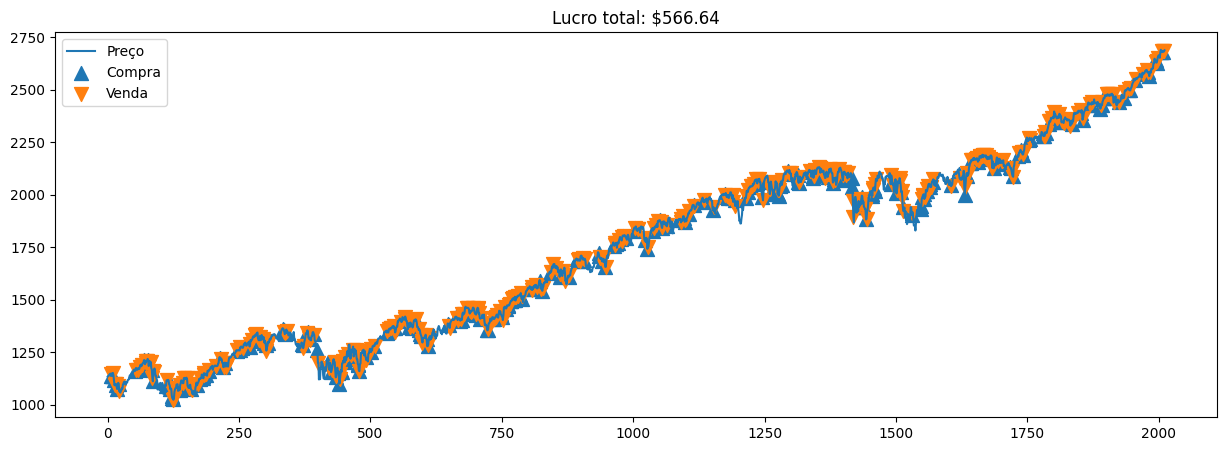

Episódios:  34%|███▍      | 17/50 [3:08:17<6:06:13, 665.87s/it]


Episódio 18 — Lucro: $2017.02


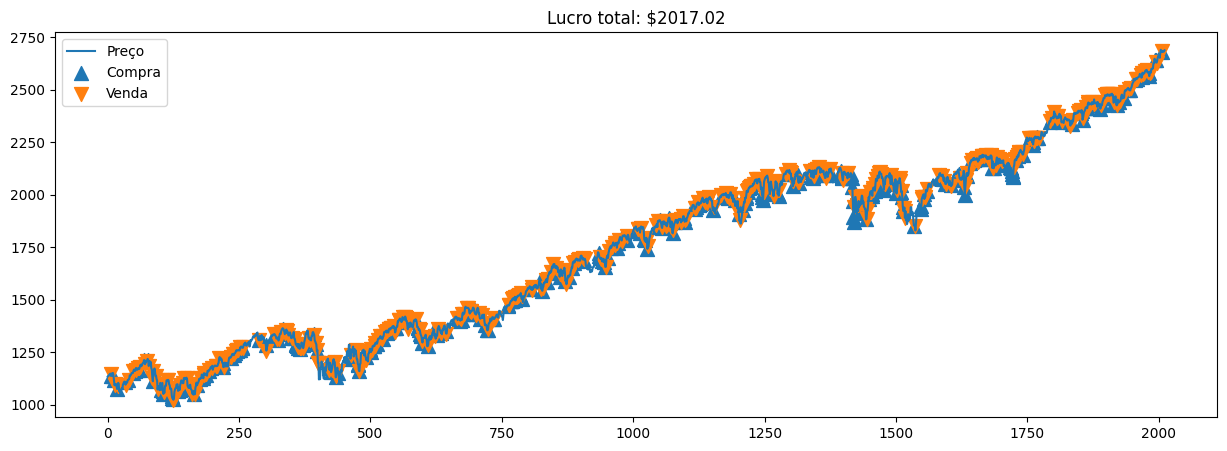

Episódios:  36%|███▌      | 18/50 [3:19:16<5:54:07, 663.98s/it]


Episódio 19 — Lucro: $2389.01


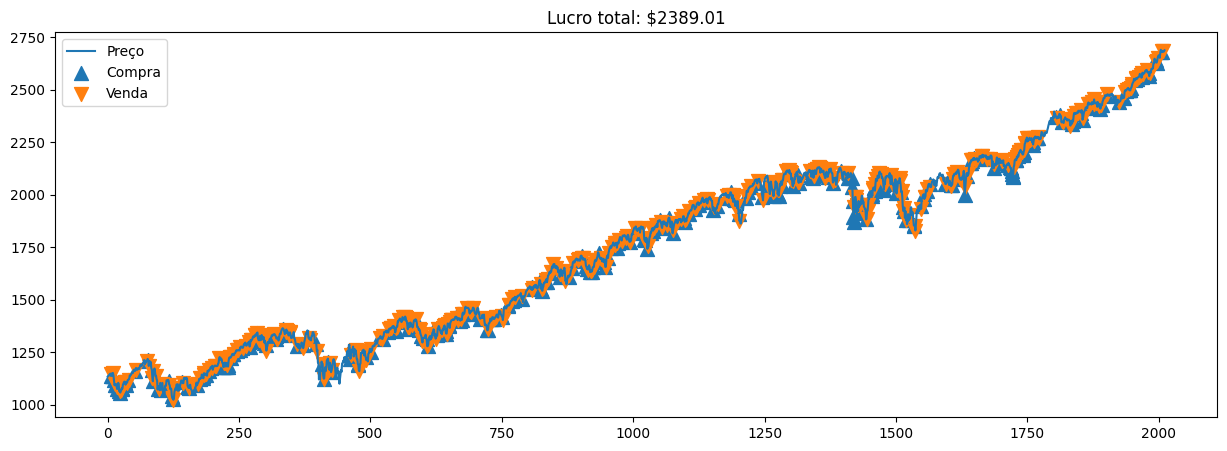

Episódios:  38%|███▊      | 19/50 [3:30:17<5:42:36, 663.12s/it]


Episódio 20 — Lucro: $852.00


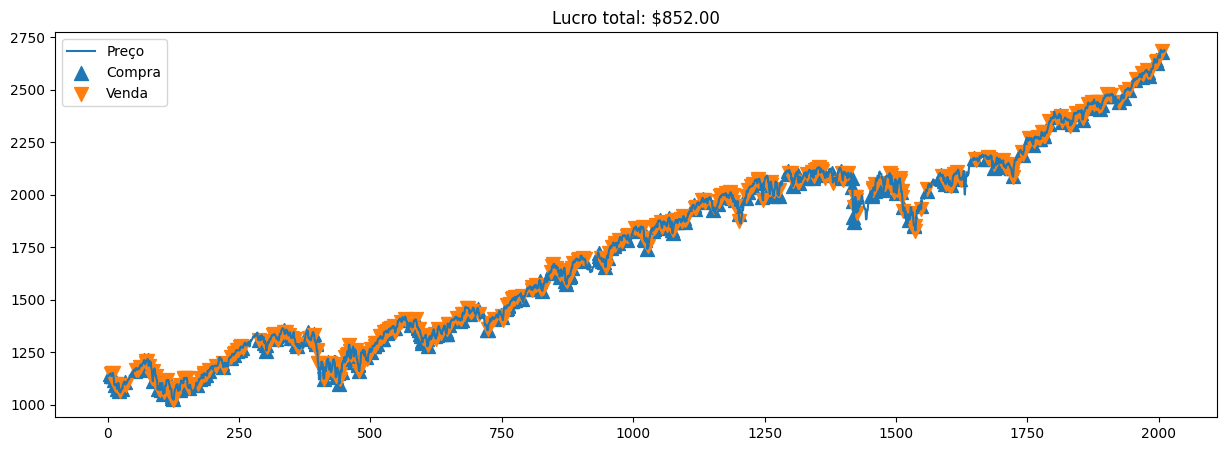

Episódios:  40%|████      | 20/50 [3:41:21<5:31:33, 663.12s/it]


Episódio 21 — Lucro: $304.83


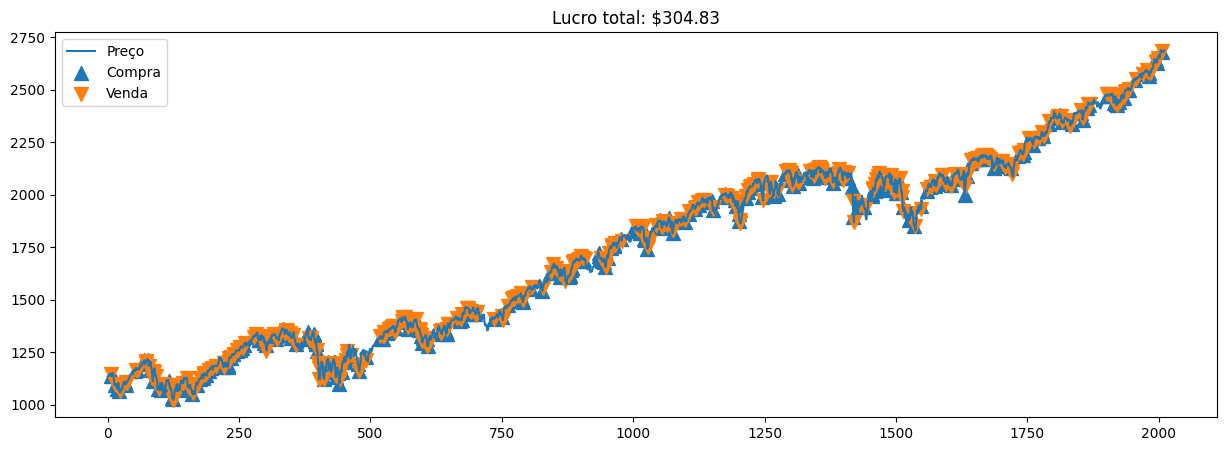

Episódios:  42%|████▏     | 21/50 [3:52:18<5:19:42, 661.46s/it]


Episódio 22 — Lucro: $622.95


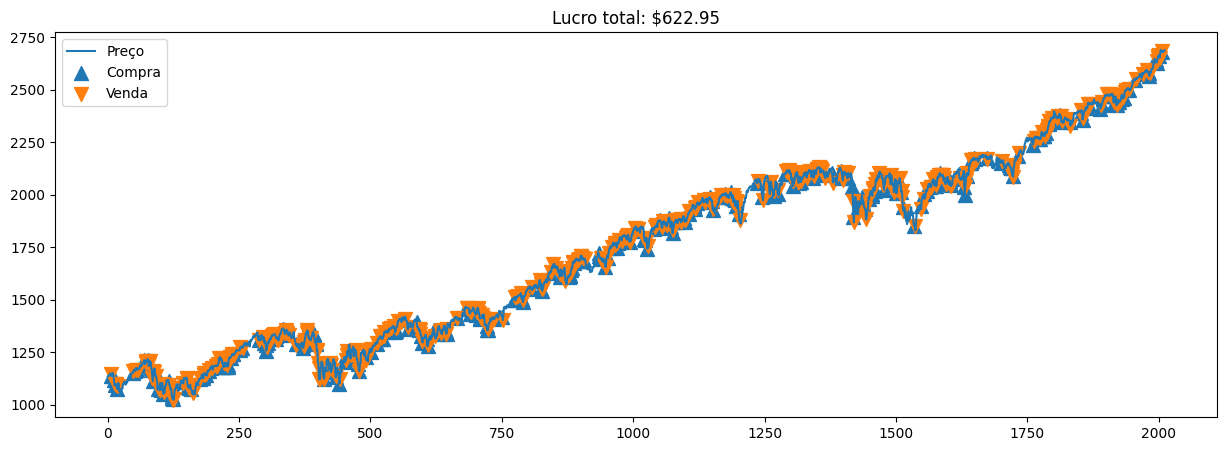

Episódios:  44%|████▍     | 22/50 [4:03:13<5:07:45, 659.48s/it]


Episódio 23 — Lucro: -$66.23


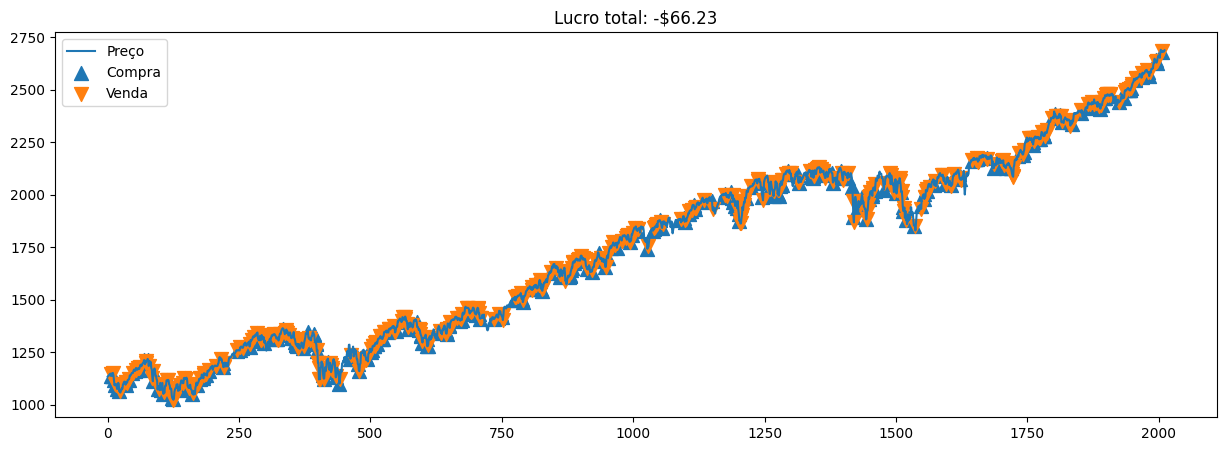

Episódios:  46%|████▌     | 23/50 [4:14:04<4:55:41, 657.09s/it]


Episódio 24 — Lucro: $918.75


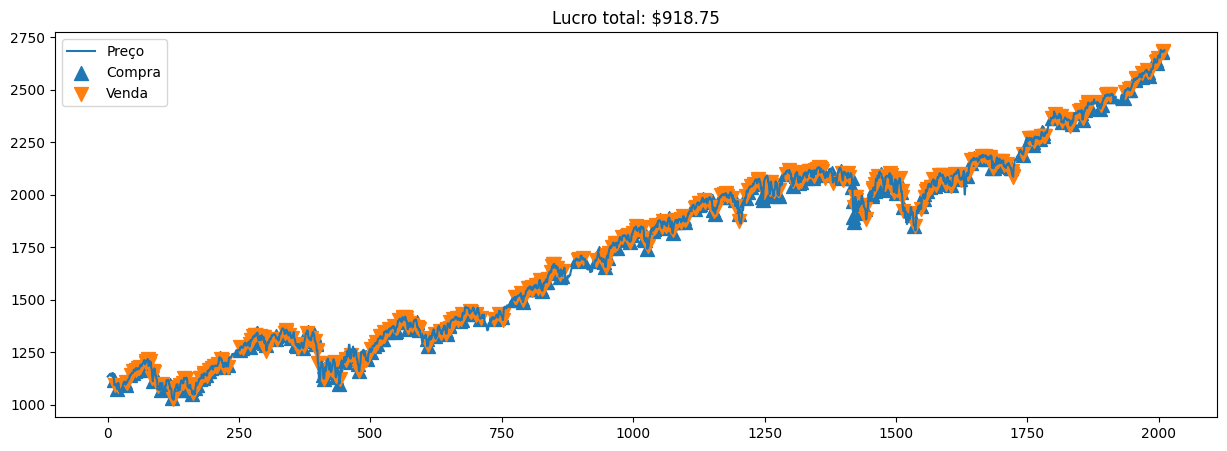

Episódios:  48%|████▊     | 24/50 [4:25:01<4:44:41, 656.99s/it]


Episódio 25 — Lucro: $754.02


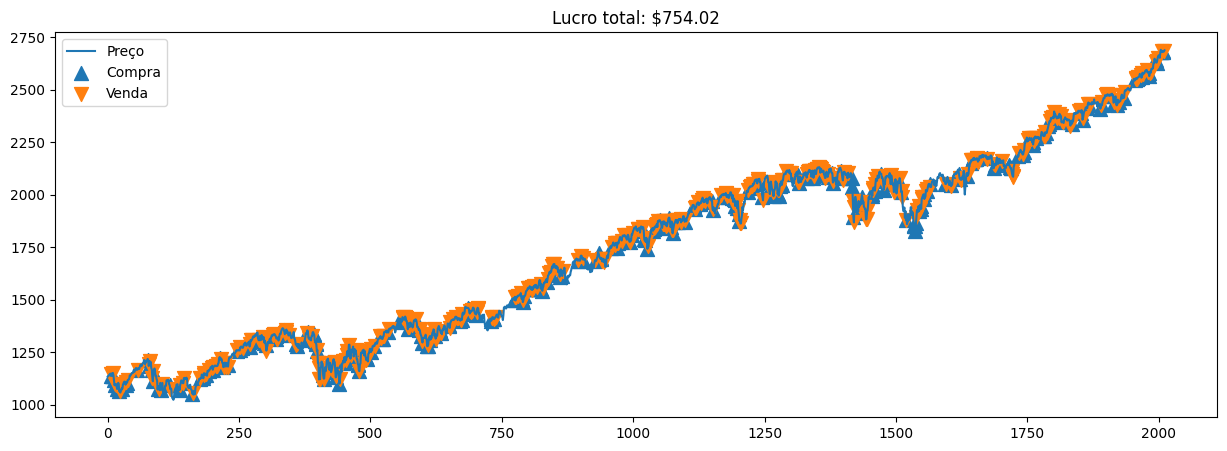

Episódios:  50%|█████     | 25/50 [4:35:57<4:33:38, 656.75s/it]


Episódio 26 — Lucro: $855.69


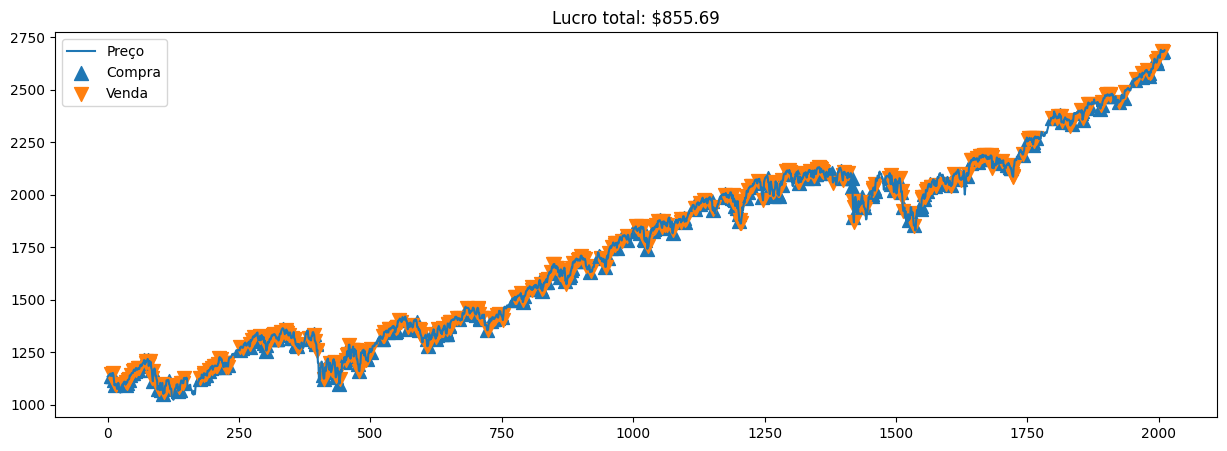

Episódios:  52%|█████▏    | 26/50 [4:46:48<4:21:55, 654.82s/it]


Episódio 27 — Lucro: $787.35


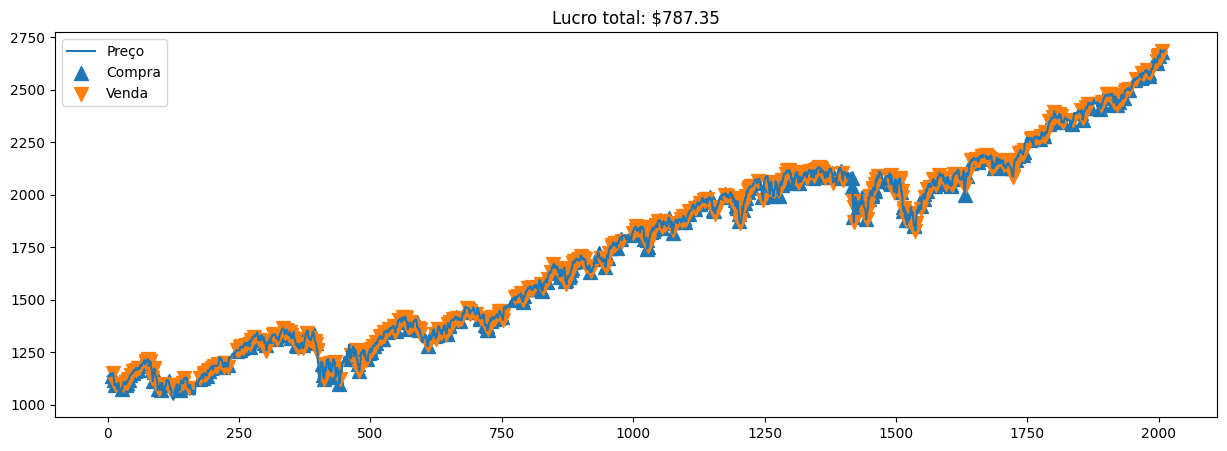

Episódios:  54%|█████▍    | 27/50 [4:57:29<4:09:28, 650.82s/it]


Episódio 28 — Lucro: $922.64


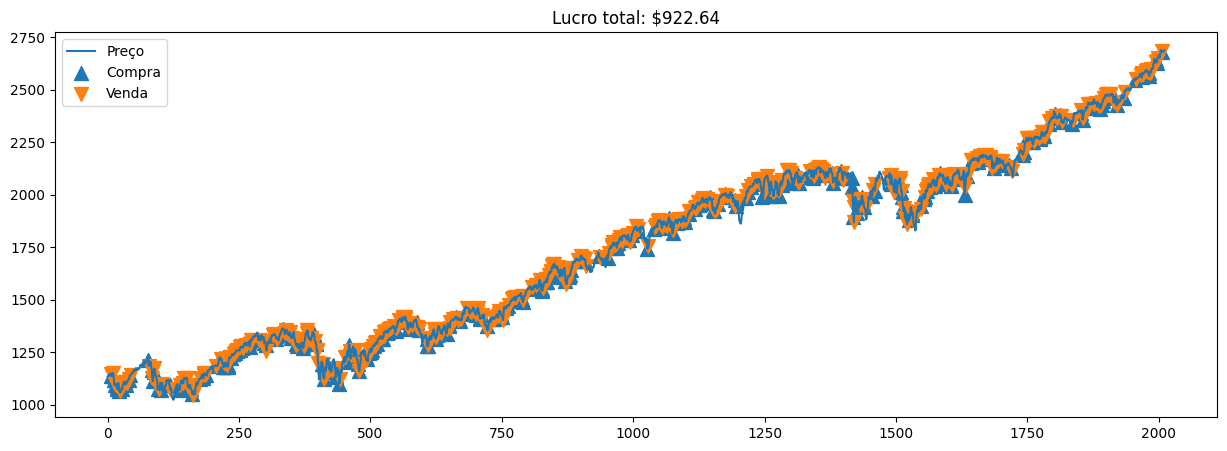

Episódios:  56%|█████▌    | 28/50 [5:07:35<3:53:43, 637.43s/it]


Episódio 29 — Lucro: $1690.90


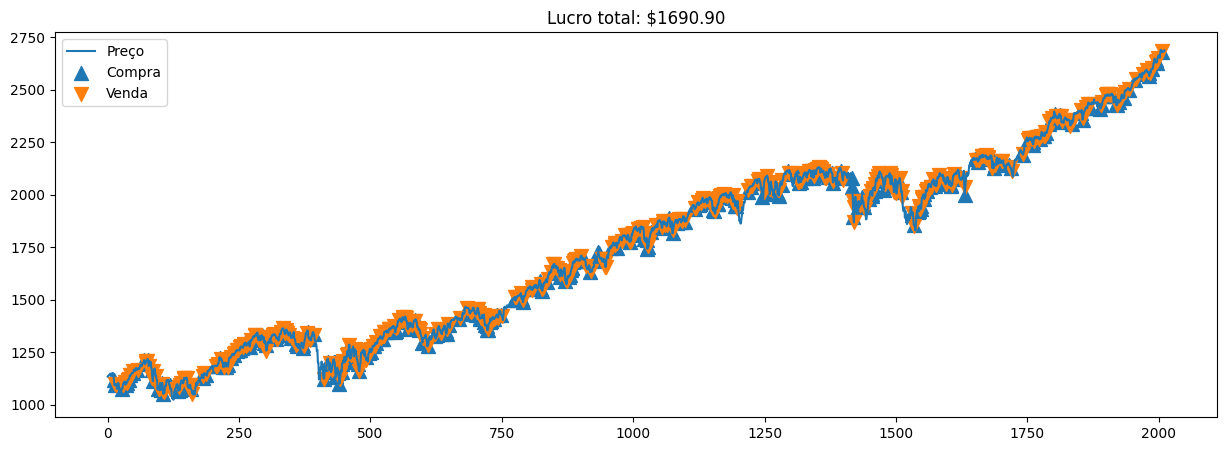

Episódios:  58%|█████▊    | 29/50 [5:17:38<3:39:24, 626.90s/it]


Episódio 30 — Lucro: $916.37


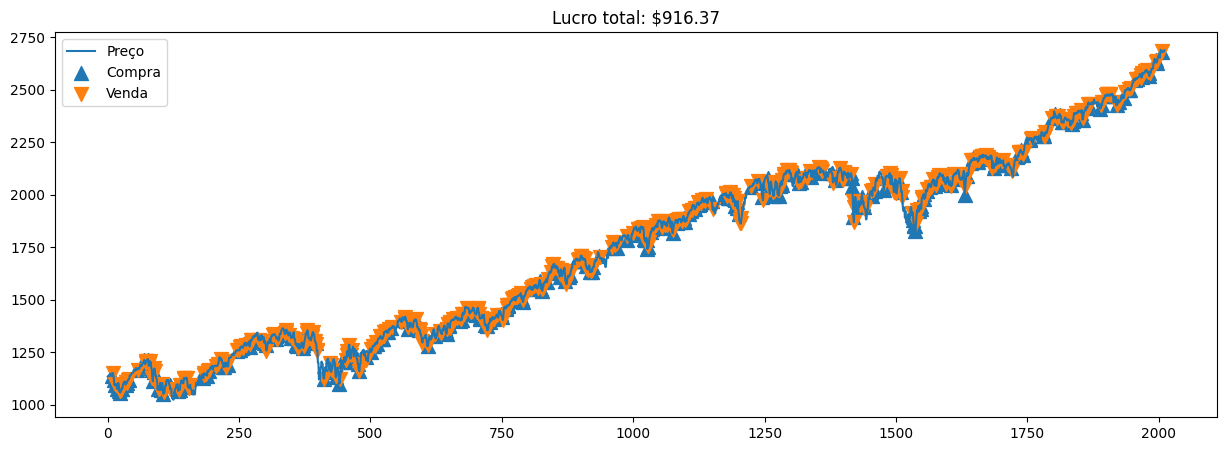

Episódios:  60%|██████    | 30/50 [5:27:41<3:26:35, 619.76s/it]


Episódio 31 — Lucro: $1615.58


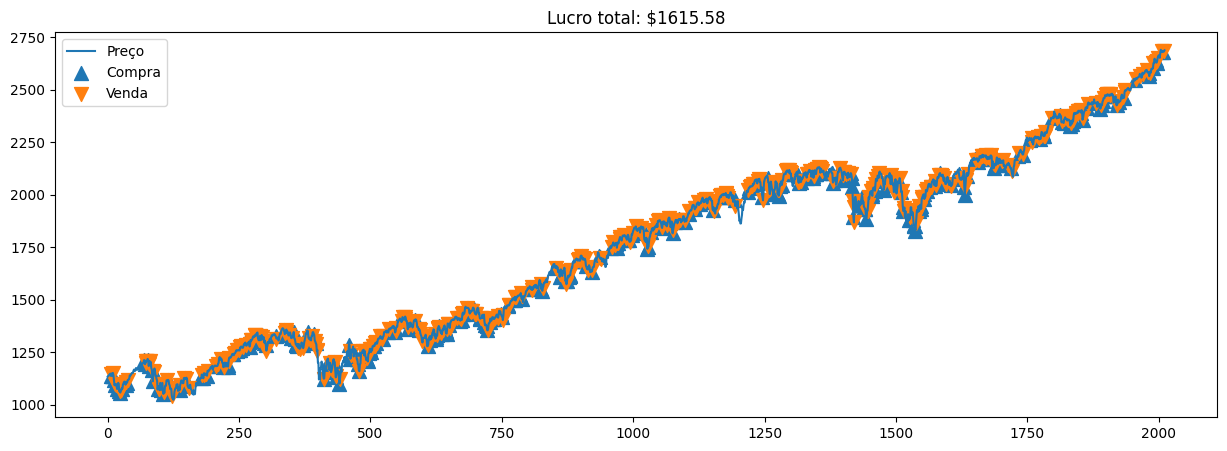

Episódios:  62%|██████▏   | 31/50 [5:37:43<3:14:32, 614.36s/it]


Episódio 32 — Lucro: $930.97


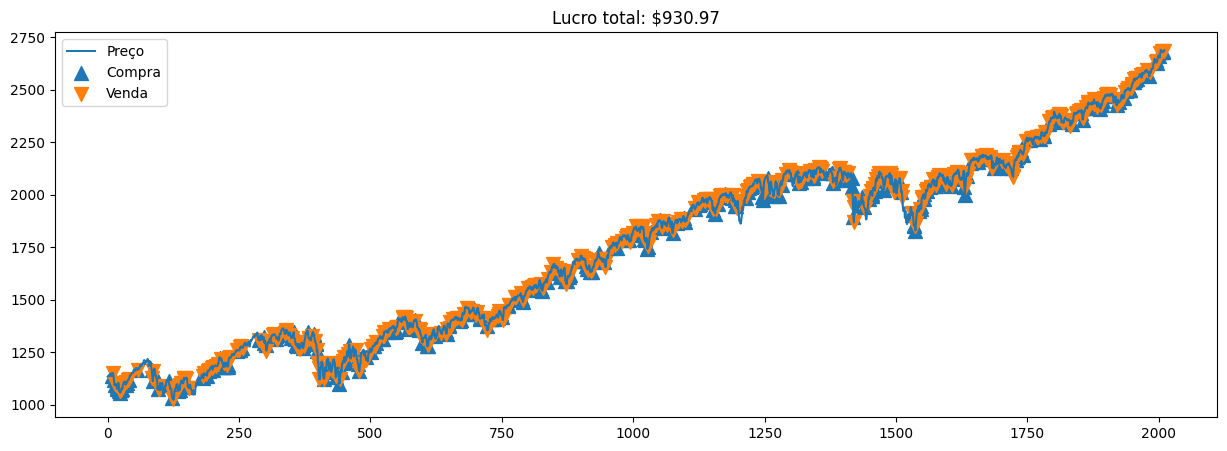

Episódios:  64%|██████▍   | 32/50 [5:47:49<3:03:35, 611.98s/it]


Episódio 33 — Lucro: $1664.64


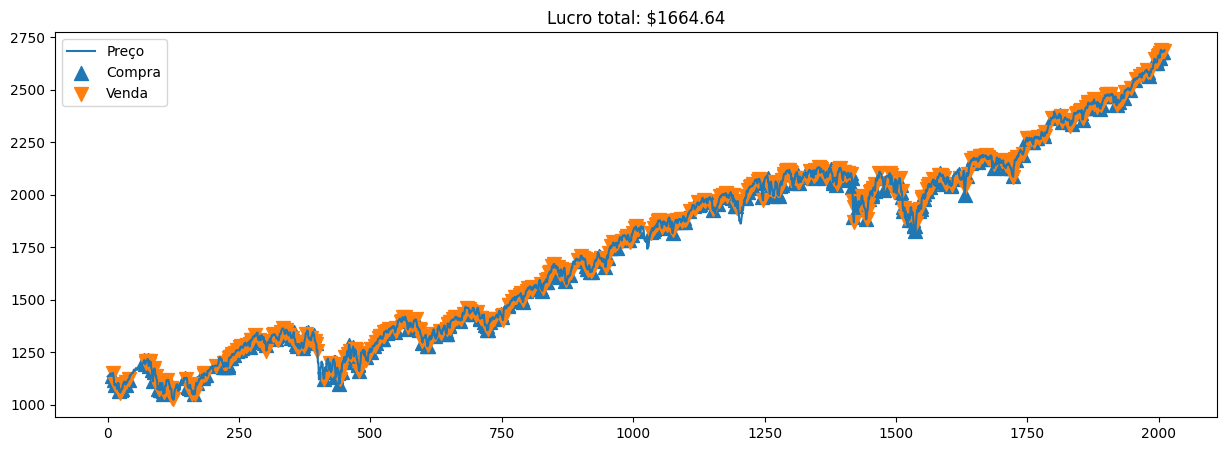

Episódios:  66%|██████▌   | 33/50 [5:57:53<2:52:44, 609.70s/it]


Episódio 34 — Lucro: $2427.92


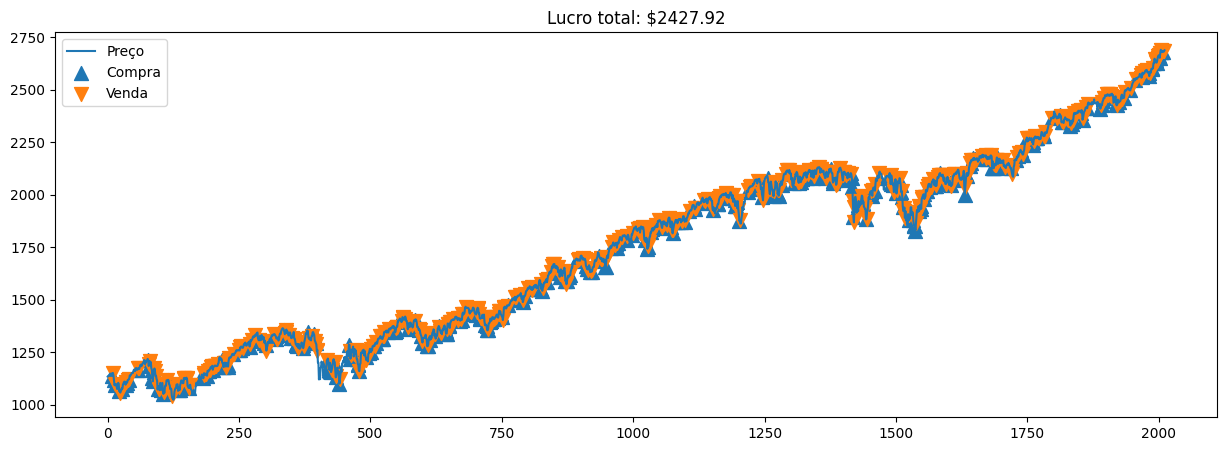

Episódios:  68%|██████▊   | 34/50 [6:07:58<2:42:09, 608.07s/it]


Episódio 35 — Lucro: $2287.30


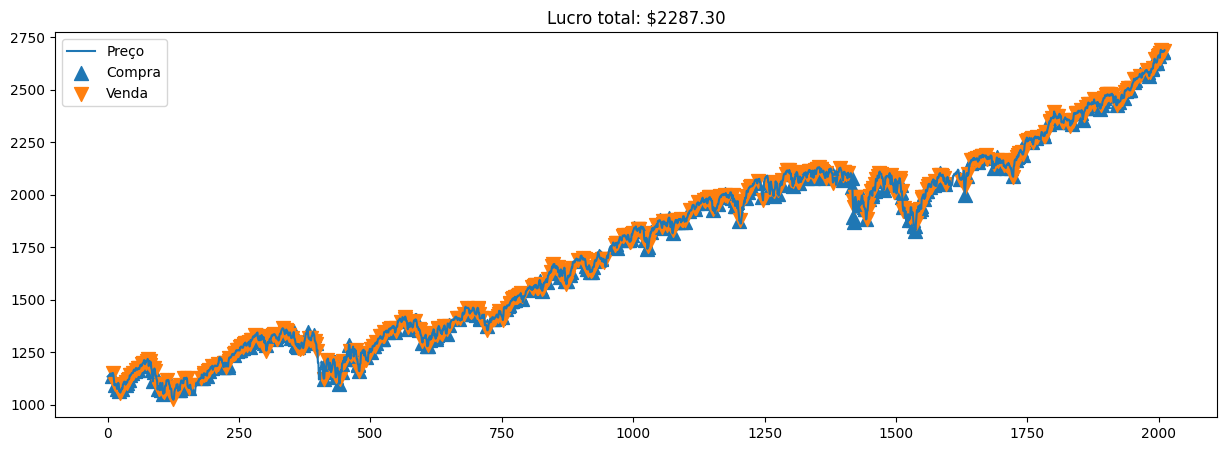

Episódios:  70%|███████   | 35/50 [6:18:03<2:31:50, 607.36s/it]


Episódio 36 — Lucro: $1534.95


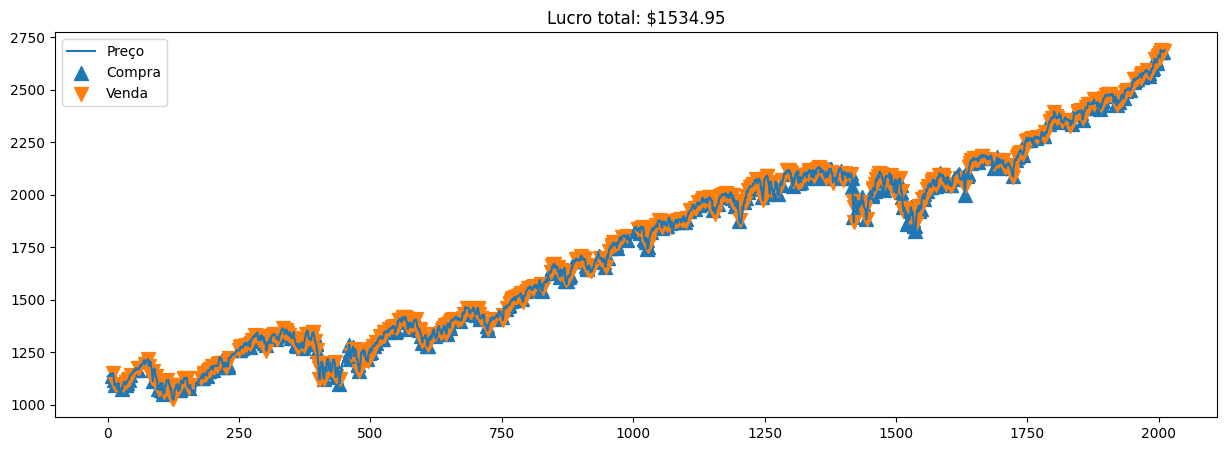

Episódios:  72%|███████▏  | 36/50 [6:28:03<2:21:11, 605.07s/it]


Episódio 37 — Lucro: $856.02


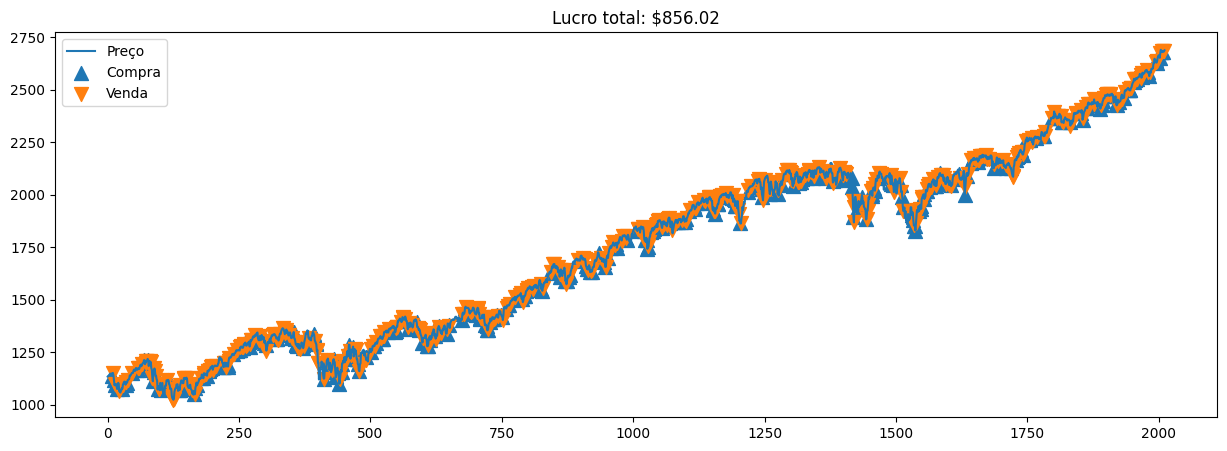

Episódios:  74%|███████▍  | 37/50 [6:38:01<2:10:36, 602.82s/it]


Episódio 38 — Lucro: $911.99


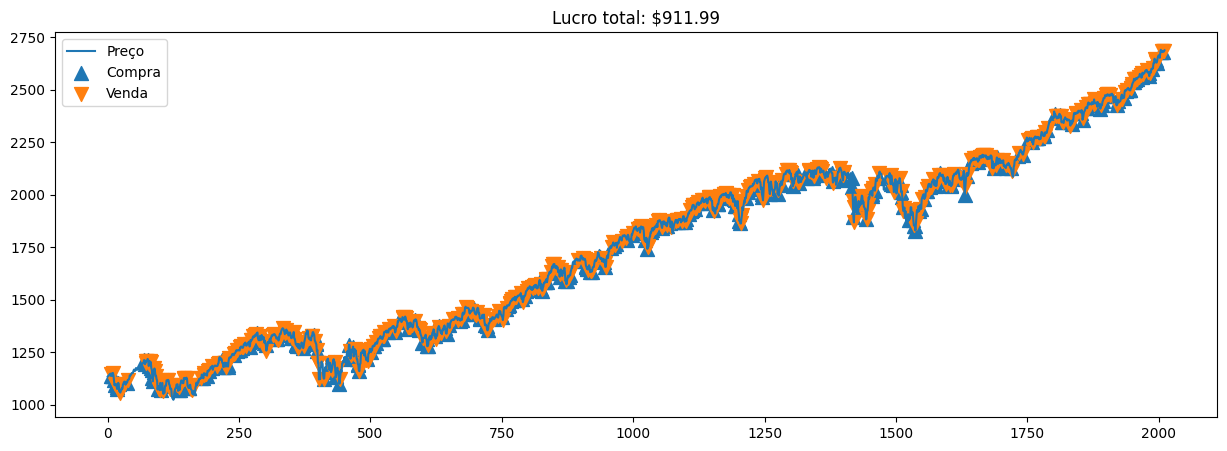

Episódios:  76%|███████▌  | 38/50 [6:47:56<2:00:05, 600.44s/it]


Episódio 39 — Lucro: $1179.83


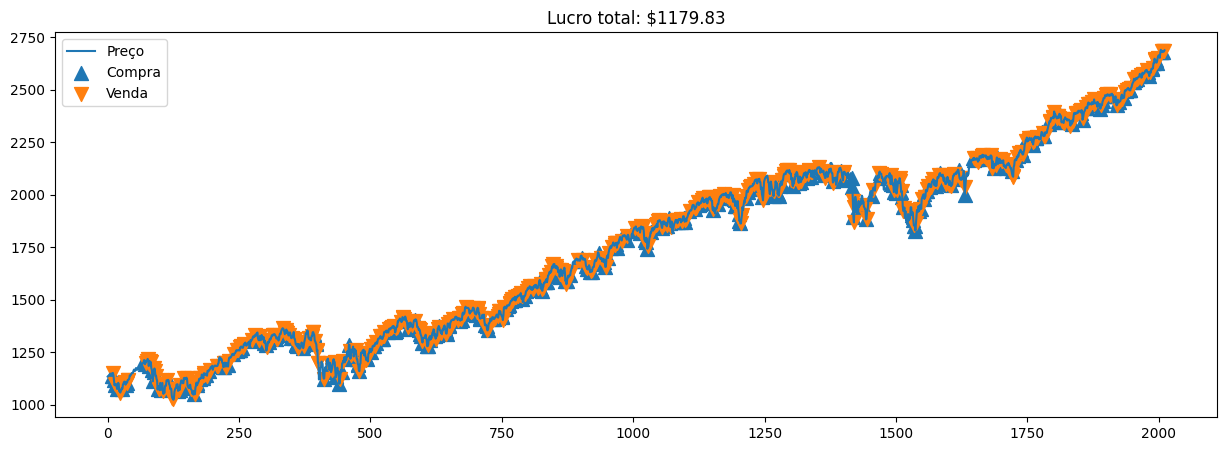

Episódios:  78%|███████▊  | 39/50 [6:57:48<1:49:37, 597.98s/it]


Episódio 40 — Lucro: $1005.47


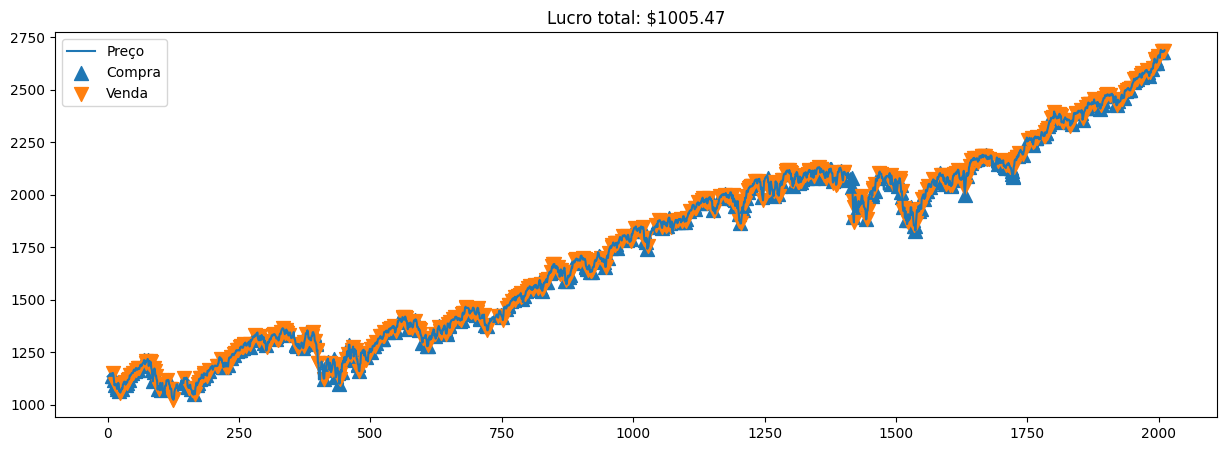

Episódios:  80%|████████  | 40/50 [7:07:33<1:39:02, 594.22s/it]


Episódio 41 — Lucro: $668.29


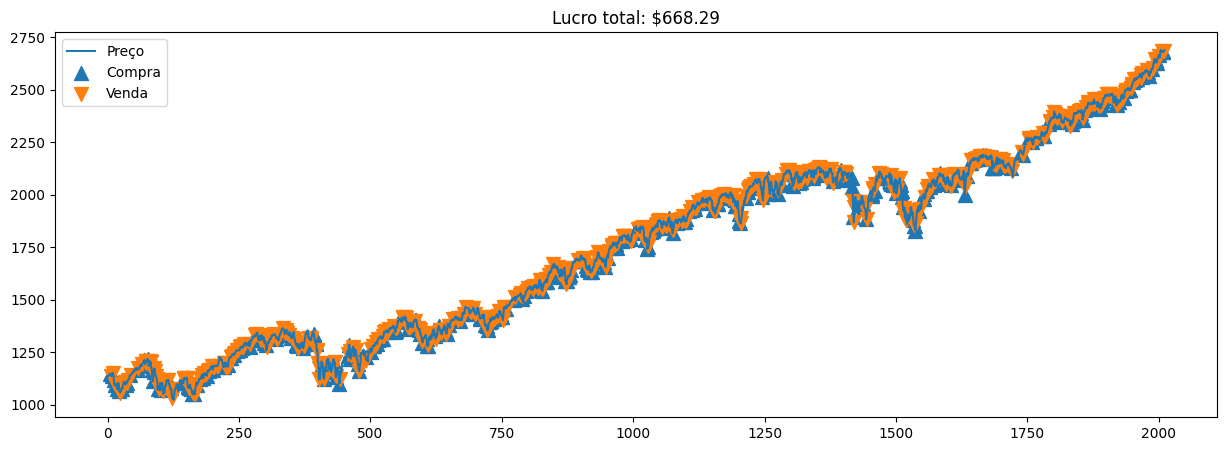

Episódios:  82%|████████▏ | 41/50 [7:17:21<1:28:49, 592.12s/it]


Episódio 42 — Lucro: $1431.77


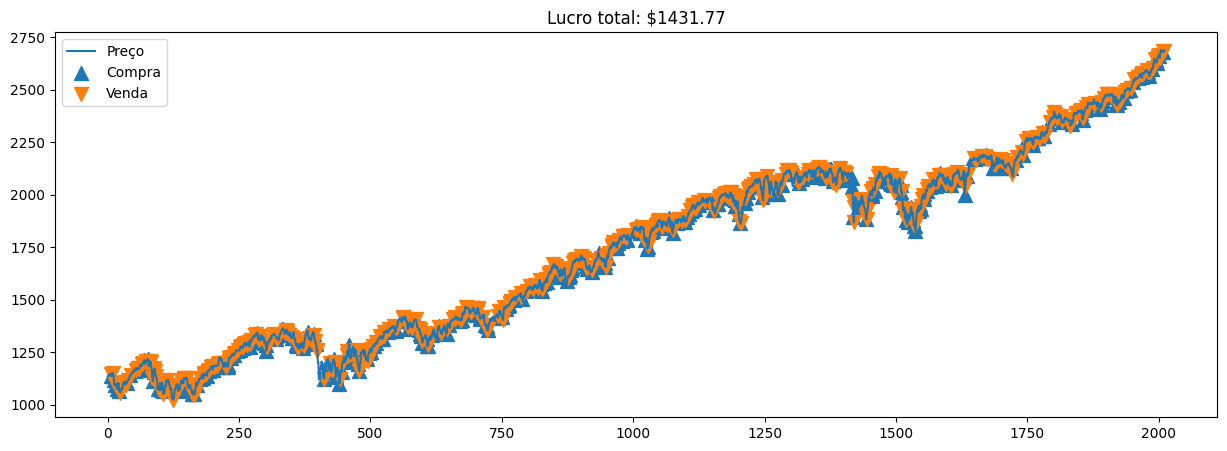

Episódios:  84%|████████▍ | 42/50 [7:27:03<1:18:33, 589.13s/it]


Episódio 43 — Lucro: $1156.07


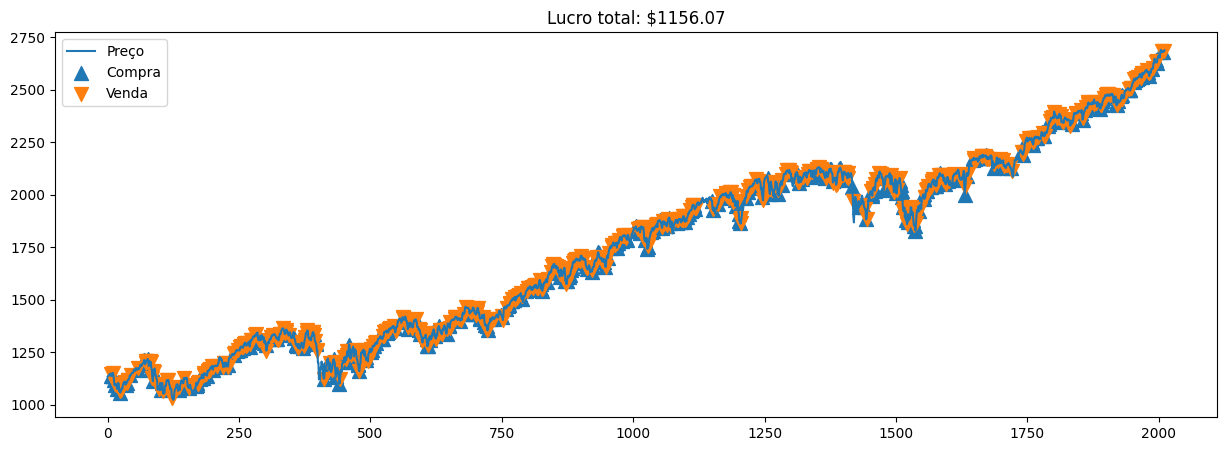

Episódios:  86%|████████▌ | 43/50 [7:36:39<1:08:17, 585.40s/it]


Episódio 44 — Lucro: $1174.73


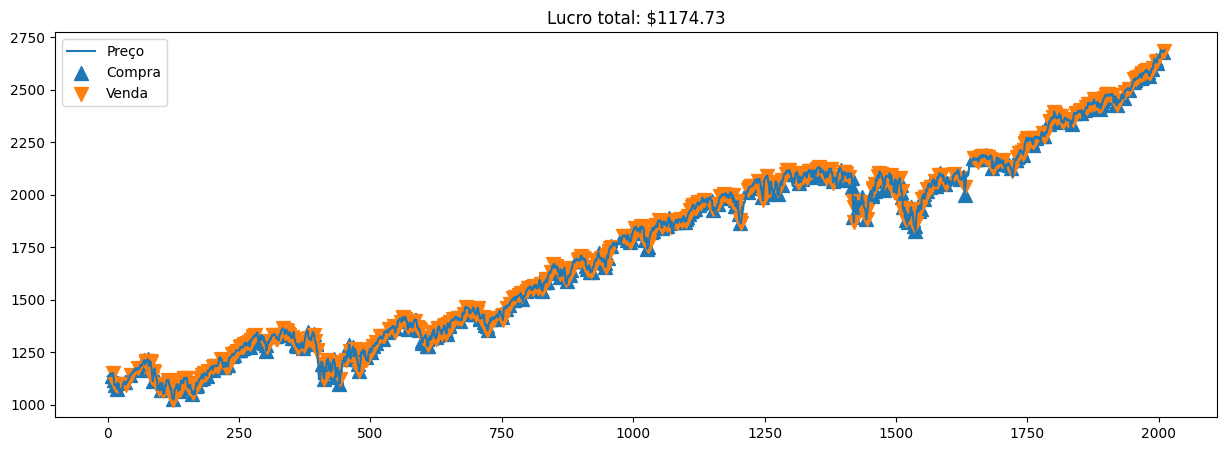

Episódios:  88%|████████▊ | 44/50 [7:46:14<58:13, 582.17s/it]  


Episódio 45 — Lucro: $709.02


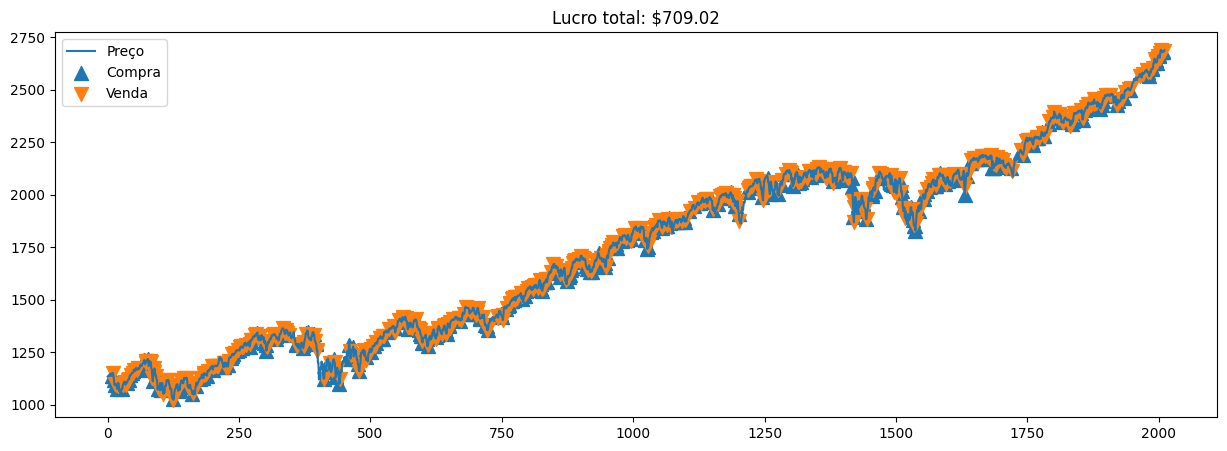

Episódios:  90%|█████████ | 45/50 [7:55:46<48:15, 579.19s/it]


Episódio 46 — Lucro: $899.50


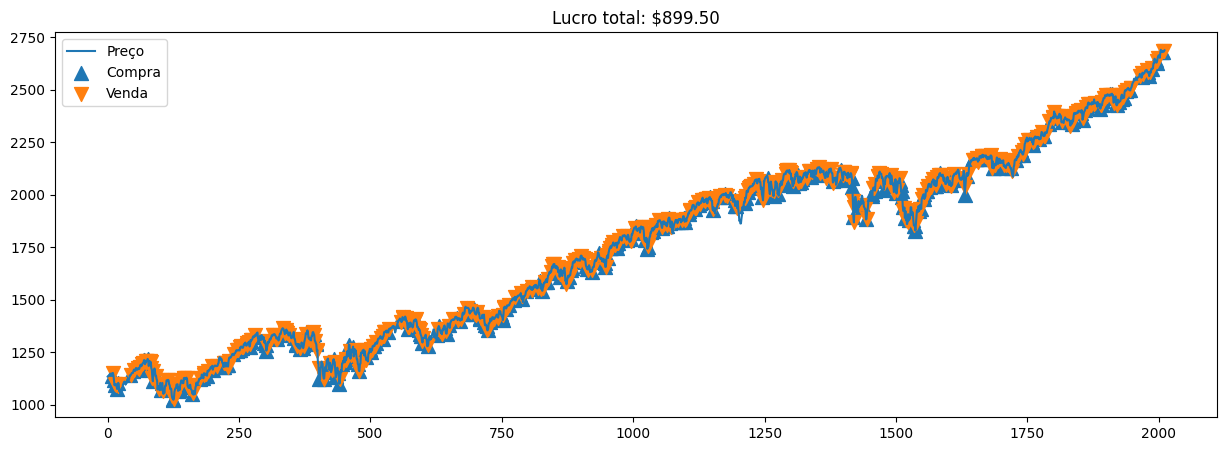

Episódios:  92%|█████████▏| 46/50 [8:05:17<38:27, 576.78s/it]


Episódio 47 — Lucro: $1723.47


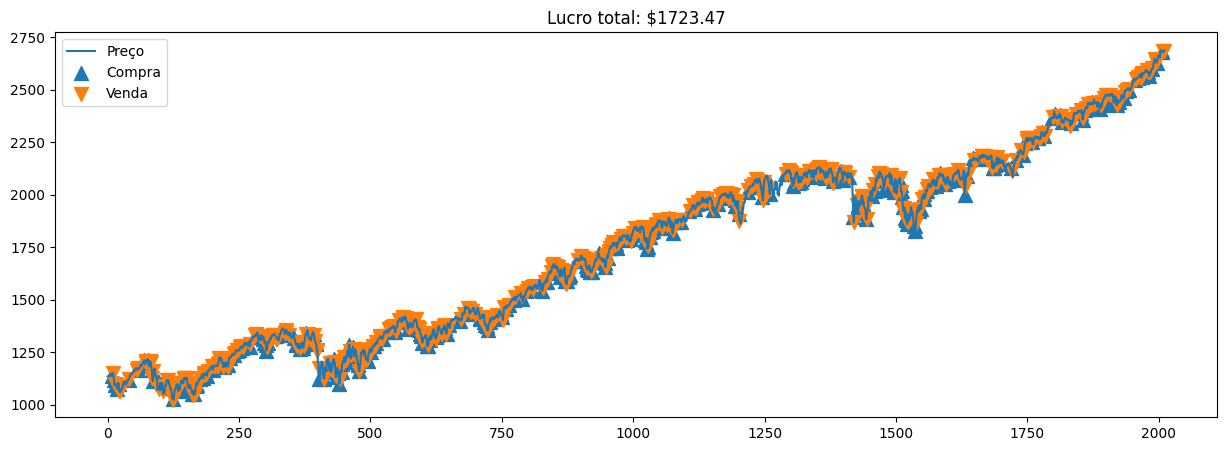

Episódios:  94%|█████████▍| 47/50 [8:14:43<28:40, 573.57s/it]


Episódio 48 — Lucro: $1083.50


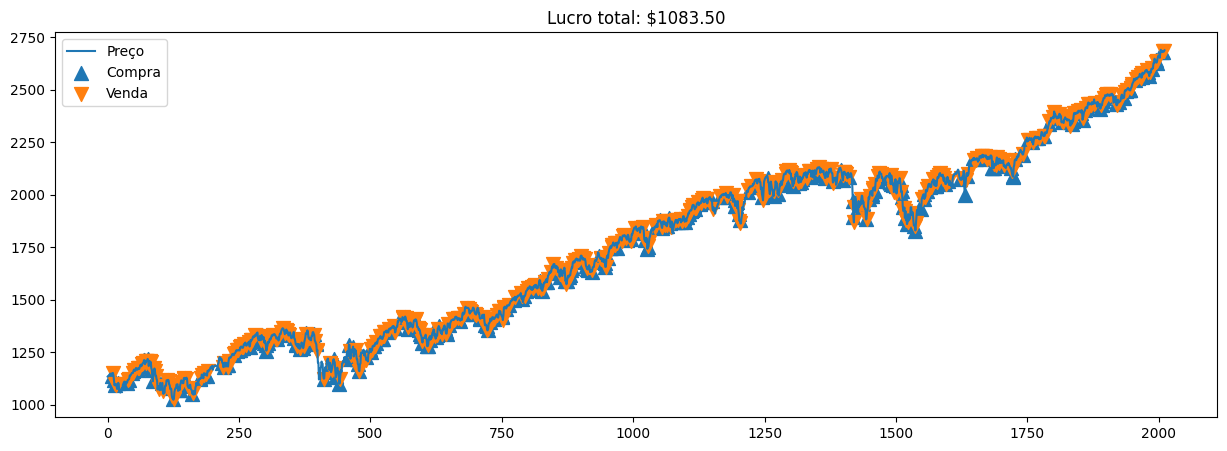

Episódios:  96%|█████████▌| 48/50 [8:24:13<19:04, 572.33s/it]


Episódio 49 — Lucro: $1845.34


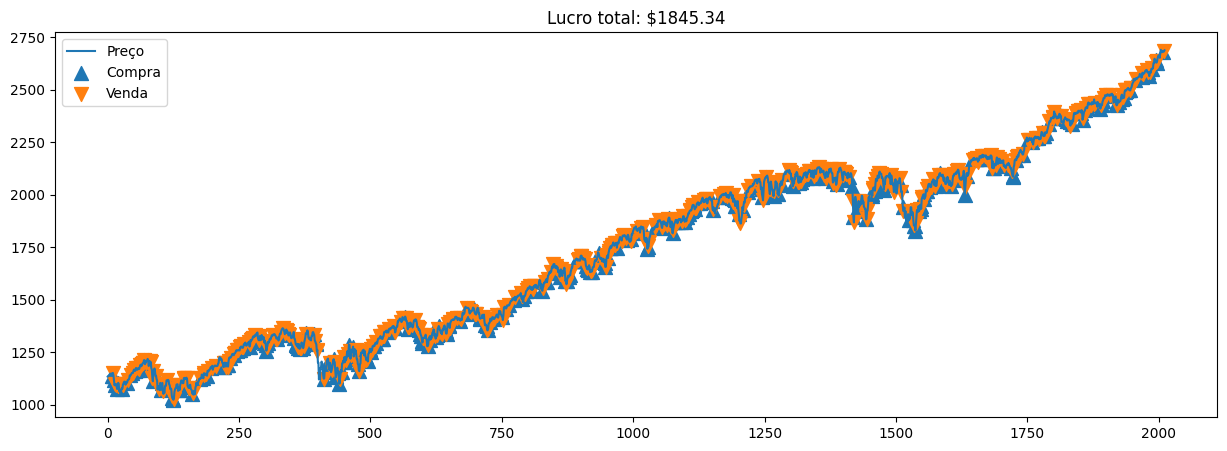

Episódios:  98%|█████████▊| 49/50 [8:33:35<09:29, 569.40s/it]


Episódio 50 — Lucro: $855.48


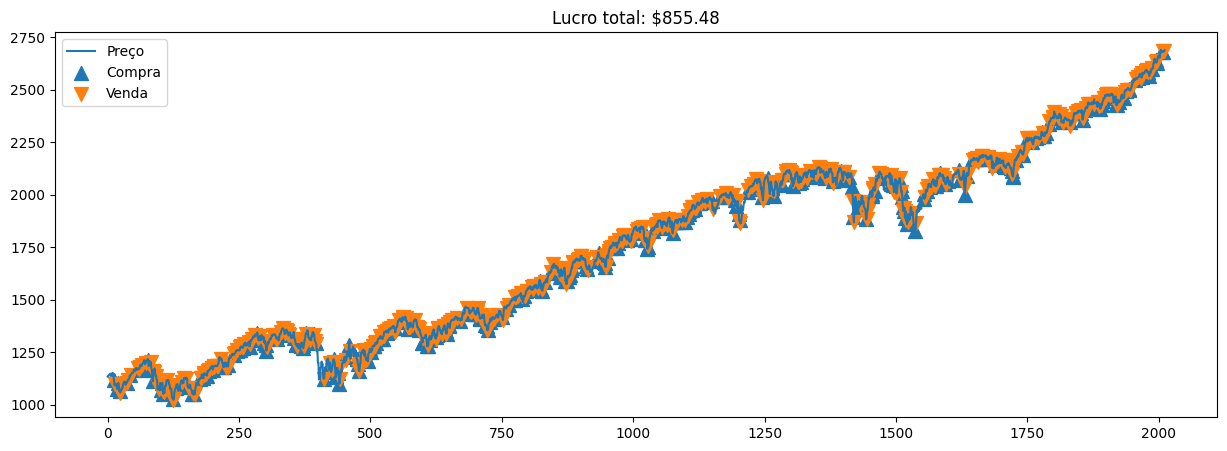

Episódios: 100%|██████████| 50/50 [8:42:57<00:00, 627.54s/it]


In [ ]:
# Hiperparâmetros de treinamento
window_size = 10
batch_size = 64
episodes = 50

agent = Agent(state_size=window_size, memory_size=20000, eps_decay=0.995)

for ep in tqdm(range(1, episodes+1), desc='Episódios'):
    state = get_state(X_train, 0, window_size+1)
    total_profit = 0
    agent.inventory.clear()
    buys, sells = [], []

    for t in range(len(X_train)-1):
        action = agent.act(state)
        next_state = get_state(X_train, t+1, window_size+1)
        reward = 0

        if action == 1:
            agent.inventory.append(X_train[t])
            buys.append(t)
        elif action == 2 and agent.inventory:
            bought = agent.inventory.pop(0)
            reward = max(X_train[t] - bought, 0)
            total_profit += X_train[t] - bought
            sells.append(t)

        done = (t == len(X_train)-2)
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            print(f"\nEpisódio {ep} — Lucro: {format_price(total_profit)}")
            plot_behavior(X_train, buys, sells, total_profit)

        if len(agent.memory) >= batch_size:
            agent.replay(batch_size)

    # Salvar modelo periodicamente
    if ep % 10 == 0:
        agent.model.save(f"model_ep{ep}.keras")


In [ ]:
#@title Deep Q-Learning Model
print(agent.model.summary())

# Teste dos Dados

In [ ]:
# Carrega o último modelo treinado
model_file = f"model_ep{episodes}.keras"
agent_eval = Agent(state_size=window_size, is_eval=True, model_name=model_file)

state = get_state(X_test, 0, window_size+1)
total_profit = 0
buys, sells = [], []

for t in range(len(X_test)-1):
    action = agent_eval.act(state)
    next_state = get_state(X_test, t+1, window_size+1)

    if action == 1:
        agent_eval.inventory.append(X_test[t])
        buys.append(t)
        print(f"Buy: {format_price(X_test[t])}")
    elif action == 2 and agent_eval.inventory:
        bought = agent_eval.inventory.pop(0)
        profit = X_test[t] - bought
        total_profit += profit
        sells.append(t)
        print(f"Sell: {format_price(X_test[t])} | Profit: {format_price(profit)}")

    state = next_state

print(f"\nLucro Total no Teste: {format_price(total_profit)}")
plot_behavior(X_test, buys, sells, total_profit)


Buy: $2748.23
Sell: $2767.56 | Profit: $19.33
Buy: $2786.24
Sell: $2802.56 | Profit: $16.32
Buy: $2798.03
Buy: $2810.30
Buy: $2839.13
Buy: $2837.54
Buy: $2872.87
Sell: $2853.53 | Profit: $55.50
Buy: $2822.43
Buy: $2823.81
Sell: $2821.98 | Profit: $11.68
Buy: $2648.94
Sell: $2695.14 | Profit: -$143.99
Sell: $2581.00 | Profit: -$256.54
Sell: $2656.00 | Profit: -$216.87
Buy: $2662.94
Sell: $2731.20 | Profit: -$91.23
Buy: $2732.22
Sell: $2716.26 | Profit: -$107.55
Buy: $2701.33
Buy: $2747.30
Buy: $2744.28
Buy: $2713.83
Buy: $2677.67
Buy: $2691.25
Buy: $2720.94
Buy: $2726.80
Sell: $2738.97 | Profit: $90.03
Buy: $2783.02
Sell: $2765.31 | Profit: $102.37
Buy: $2749.48
Sell: $2747.33 | Profit: $15.11
Buy: $2752.01
Buy: $2712.92
Sell: $2716.94 | Profit: $15.61
Buy: $2643.69
Sell: $2588.26 | Profit: -$159.04
Buy: $2612.62
Sell: $2605.00 | Profit: -$139.28
Buy: $2640.87
Buy: $2644.69
Sell: $2662.84 | Profit: -$50.99
Buy: $2604.47
Buy: $2613.16
Sell: $2663.99 | Profit: -$13.68
Buy: $2656.30
Buy: $

Sell: $5996.66 | Profit: $59.32
Sell: $6118.71 | Profit: $32.34
Sell: $6067.70 | Profit: -$33.54
Sell: $6039.31 | Profit: $27.03
Sell: $6037.88 | Profit: $43.31
Sell: $5955.25 | Profit: -$57.88
Sell: $5861.57 | Profit: -$121.68
Sell: $5954.50 | Profit: -$1.56
Sell: $5638.94 | Profit: $117.42
Sell: $5611.85 | Profit: -$100.35
Sell: $5633.07 | Profit: -$60.24
Sell: $5670.97 | Profit: $90.03
Sell: $5456.90 | Profit: $60.38
Sell: $5268.05 | Profit: $193.97
Sell: $5363.36 | Profit: $380.59
Sell: $5282.70 | Profit: $7.00

Lucro Total na inferência: $636.14


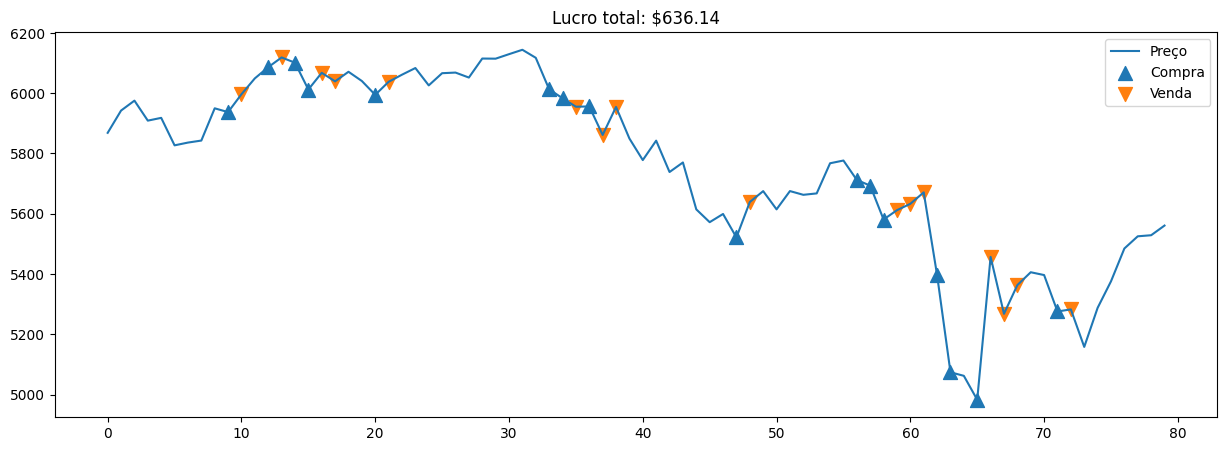

In [ ]:
# --- 1) Parâmetros principais (ajuste conforme seu modelo) ---
WINDOW_SIZE = 10
MODEL_FILE  = '/content/model_ep30.keras'   # nome do seu arquivo .keras gerado no treino

# --- 2) Funções auxiliares (mesmas do Código 01) ---
def get_state(data, t, n):
    start = max(0, t - n + 1)
    block = data[start:t+1]
    if len(block) < n:
        block = [data[0]]*(n-len(block)) + block
    diffs = np.diff(block)
    return expit(diffs).reshape(1, -1)

def format_price(n):
    sign = '-' if n < 0 else ''
    return f"{sign}${abs(n):.2f}"

def plot_behavior(data, buys, sells, profit):
    plt.figure(figsize=(15,5))
    plt.plot(data, label='Preço')
    plt.scatter(buys, [data[i] for i in buys], marker='^', s=100, label='Compra')
    plt.scatter(sells, [data[i] for i in sells], marker='v', s=100, label='Venda')
    plt.title(f'Lucro total: {format_price(profit)}')
    plt.legend()
    plt.show()

# --- 3) Carrega e limpa o CSV do Nifty50 (ou SP500_2025) ---
df = pd.read_csv('/content/sp500_2025.csv')

# descarta as duas linhas de metadados iniciais
df = df.iloc[2:].copy()

# renomeia e converte a coluna "Price" para datetime
df.rename(columns={'Price': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# define Date como índice e ordena
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# preenche eventuais nulos
df.fillna(method='ffill', inplace=True)

# --- 4) Extrai lista de preços de fechamento ---
prices = df['Close'].astype(float).tolist()
X_test = prices

# --- 5) Define o Agent em modo avaliação ---
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size
        self.action_size = 3
        self.inventory = []
        self.memory = deque(maxlen=20000)
        self.gamma = 0.95
        # sem exploração em inferência
        self.epsilon = 0.0
        self.model = load_model(model_name) if is_eval else None

    def act(self, state):
        q = self.model.predict(state, verbose=0)
        return np.argmax(q[0])

agent = Agent(state_size=WINDOW_SIZE, is_eval=True, model_name=MODEL_FILE)

# --- 6) Loop de inferência ---
state = get_state(X_test, 0, WINDOW_SIZE+1)
total_profit = 0
buys, sells = [], []

for t in range(len(X_test)-1):
    action = agent.act(state)
    next_state = get_state(X_test, t+1, WINDOW_SIZE+1)

    if action == 1:
        agent.inventory.append(X_test[t])
        buys.append(t)
    elif action == 2 and agent.inventory:
        bought = agent.inventory.pop(0)
        profit = X_test[t] - bought
        total_profit += profit
        sells.append(t)
        print(f"Sell: {format_price(X_test[t])} | Profit: {format_price(profit)}")

    state = next_state

# --- 7) Resultados ---
print(f"\nLucro Total na inferência: {format_price(total_profit)}")
plot_behavior(X_test, buys, sells, total_profit)